In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from scipy.optimize import curve_fit
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import precision_recall_fscore_support
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression

In [2]:
root_path = os.path.abspath(os.path.join('..', '..'))

In [ ]:
def get_model_path(root_path, device, model_type, cv, use_noise_clean=False):
    path = root_path
    # if device contains 'RLA' or 'LLA'
    if 'RLA' in device or 'LLA' in device:
        if use_noise_clean:
            parent_path = os.path.join(path, 'data', 'no_noise', 'Run_logs', device, 'logs')
        else:
            parent_path = os.path.join(path, 'data', 'Run_logs', device, 'logs')
    else:
        parent_path = os.path.join(path, 'data', 'Run_logs', device, 'logs')
    # parent paths has three folders for attend, deepCONV, TinyHAR. Get a list of all folders in the parent path
    folders = os.listdir(parent_path)
    for folder in folders:
        if model_type in folder:
            path = os.path.join(parent_path, folder)
            break
    # path now has the path to the model type folder
    path = os.path.join(path, 'cv_' + str(cv))
    return path


def create_confusion(root_path, model_device, test_device, model_type, cv):
    path = get_model_path(root_path, model_device, model_type, cv)
    filename = 'prediction_result_' + model_device + '_' + test_device + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    # Assuming binary classification
    num_classes = 2
    # plot a confusion matrix
    cm = confusion_matrix(trues, preds)
    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def get_result_for_model(root_path, model_device, test_device, model_type, cv, use_noise_clean=False):
    if 'RLA' in model_device or 'LLA' in model_device:
        path = get_model_path(root_path, model_device, model_type, cv, use_noise_clean)
        filename = 'prediction_result_' + model_device + '_' + test_device + '.csv'
        path = os.path.join(path, filename)
        # open the csv file prediction_result_ and read the data
        csv_file = path
        # open with pandas
        df = pd.read_csv(csv_file)
        # if the file is empty, continue
        if df.empty:
            return None

        # get the prediction result
        preds = df['preds'].values
        # get the ground truth
        trues = df['trues'].values

        num_classes = 34
        classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                   26, 27, 28, 29, 30, 31, 32, 33]

        # Calculate precision, recall, and f1 for each class. Use zero devision as 0
        precision, recall, f1_weighted, _ = precision_recall_fscore_support(trues, preds, labels=classes,
                                                                            average='weighted', zero_division=0)
        # Calculate macro
        _, _, f1_macro, _ = precision_recall_fscore_support(trues, preds, labels=classes, average='weighted',
                                                            zero_division=0)

        accuracy = np.sum(preds == trues) / len(preds)

        return accuracy, precision, recall, f1_macro, f1_weighted  #, preds, trues
    else:
        path = get_model_path(root_path, model_device, model_type, cv)
        filename = 'prediction_result_' + model_device + '_' + test_device + '.csv'
        path = os.path.join(path, filename)
        # open the csv file prediction_result_ and read the data
        csv_file = path
        # open with pandas
        df = pd.read_csv(csv_file)
        # if the file is empty, continue
        if df.empty:
            print('Empty file: ', path)
            return None

        # get the prediction result
        preds = df['preds'].values
        # get the ground truth
        trues = df['trues'].values

        # Assuming binary classification
        num_classes = 2

        # Calculate precision, recall, and f1 for each class
        precision, recall, f1, _ = precision_recall_fscore_support(trues, preds, average=None)

        # Calculate accuracy
        accuracy = np.sum(preds == trues) / len(preds)

        # Calculate macro F1
        f1_macro = np.mean(f1)

        # Calculate weighted F1
        class_distribution = np.bincount(trues)
        f1_weighted = np.sum(f1 * class_distribution / len(trues))

        # accuracy = np.sum(preds == trues) / len(preds)
        # precision = np.sum((preds == 1) & (trues == 1)) / np.sum(preds == 1)
        # recall = np.sum((preds == 1) & (trues == 1)) / np.sum(trues == 1)
        # f1 = 2 * np.sum((preds == 1) & (trues == 1)) / (np.sum(preds == 1) + np.sum(trues == 1))
        # f1_w = (precision + recall) / 2

    return accuracy, precision, recall, f1_macro, f1_weighted  #, preds, trues

In [4]:
# Method for creating a multi bar graph with x axis and y axis values in the for of a list
'''
x: list of x axis labels
y: list of y axis values
x_label: x axis label
y_label: y axis label
title: title of the graph
width: width of the graph
height: height of the graph
bar_width: width of each bar
'''
from dataloaders.dataloader_HARVAR_har import HARVAR_CV


def generate_multi_bar_graph(data_frame, x_label, y_label, title, width, height, bar_width, std=False):
    # set the width of the bars
    bar_width = bar_width
    sns.barplot(data_frame, x=x_label, y=y_label, palette='dark', errorbar='sd' if std else None)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(width, height)
    plt.show()


def get_f1_df(model_device, test_devices):
    data = {'Device': [], 'F1 Score': [], 'model_type': [], 'cv': []}
    df = pd.DataFrame(data)
    for device in test_devices:
        for i in range(num_participants):
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'attend', i)[3],
                       'model_type': 'attend',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'deepconv', i)[3],
                       'model_type': 'deepconv',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'tinyhar', i)[3],
                       'model_type': 'tinyhar',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    return df


def generate_graph_with_std(root_path, model_device, test_devices):
    df = get_f1_df(model_device, test_devices)

    # generate the graph
    g = sns.catplot(x='Device', y='F1 Score', hue='model_type', data=df, kind='bar', palette='dark', errorbar='sd',
                    alpha=.6, height=6, aspect=2).set(title='F1 Score for Model trained with ' + model_device)
    g.despine(left=True)
    g.set_ylabels('F1 Score')
    g.set_xlabels('Device')
    g.set_xticklabels(rotation=45)

    # save the graph in folder mean_graphs in the logs, create folder if not exists
    if not os.path.exists(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs')):
        os.makedirs(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs'))
    # plt.savefig(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs',
    #                          'F1 Score for Model trained with ' + model_device + '.png'))


def check_var(sensor1, sensor2):
    if sensor1 in ['empatica-left', 'empatica-right'] and sensor2 in ['empatica-left', 'empatica-right']:
        return "Position Variability"
    elif sensor1 in ['bluesense-LWR', 'bluesense-RWR1'] and sensor2 in ['bluesense-LWR', 'bluesense-RWR1']:
        return "Position Variability"
    elif sensor1 in ['bluesense-RWR1', 'bluesense-RWR2'] and sensor2 in ['bluesense-RWR1', 'bluesense-RWR2']:
        return "Orientation Variability"
    elif sensor1 in ['empatica-left', 'bluesense-LWR'] and sensor2 in ['empatica-left', 'bluesense-LWR']:
        return "Device Variability"
    elif sensor1 in ['empatica-right', 'bluesense-RWR1'] and sensor2 in ['empatica-right', 'bluesense-RWR1']:
        return "Device Variability"
    else:
        return "realdisp"


In [5]:
sensor_abbrev = {'empatica-left': 'EL', 'empatica-right': 'ER', 'bluesense-LWR': 'BL', 'bluesense-RWR1': 'BR1',
                 'bluesense-RWR2': 'BR2', 'RLA-ideal': 'RLA-Ideal', 'RLA-self': 'RLA-Self', 'LLA-ideal': 'LLA-Ideal',
                 'LLA-self': 'LLA-Self'}

In [6]:
model_list = ['attend', 'deepconv', 'tinyhar']

In [7]:
# All the sensors used in the experiment
sensor_list = [['empatica-left', 'empatica-right'], ['empatica-right', 'empatica-left'],
               ['empatica-left', 'bluesense-LWR'], ['bluesense-LWR', 'empatica-left'],
               ['bluesense-RWR1', 'bluesense-RWR2'], ['bluesense-RWR2', 'bluesense-RWR1'],
               ['bluesense-LWR', 'bluesense-RWR1'],
               ['bluesense-RWR1', 'bluesense-LWR']]
sensor_list_realdisp = [['RLA-ideal', 'RLA-self'], ['RLA-self', 'RLA-ideal'], ['LLA-ideal', 'LLA-self'],
                        ['LLA-self', 'LLA-ideal']]
# sensor_list = [['bluesense-LWR', 'bluesense-LWR']]
# Selected Sensors
# sensor_list = [['empatica-right', 'empatica-left'], ['empatica-left', 'bluesense-LWR'],
#                ['bluesense-RWR2', 'bluesense-RWR1']]

In [8]:
# 17 for real disp
num_participants = 16
num_participants_realdisp = 16

In [9]:
# 17 for real disp
num_participants = 16

corr_data = {}
slope_data = {}

final_table = pd.DataFrame()

for pair in sensor_list:
    print(pair)
    sensor_test = pair[0]
    sensor_train = pair[1]
    result_list = []

    for i in range(num_participants):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break

            dict_results = {'f1': result1[3],
                            'cv': i + 1, 'train': sensor_train, 'test': sensor_test, 'model_type': model,
                            'device_config': sensor_train + ' vs ' + sensor_test}
            result_list.append(dict_results)
            dict_results = {'f1': result2[3],
                            'cv': i + 1, 'train': sensor_test, 'test': sensor_test, 'model_type': model,
                            'device_config': sensor_test + ' vs ' + sensor_test}
            result_list.append(dict_results)

    df = pd.DataFrame(result_list)

    file_activity = 'using_3d_per_activity'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    ''' Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 0]
    mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 0]

    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # if sensor_test is RWR1 then drop cv 17
    if sensor_test == 'bluesense-RWR1':
        # increment CV values greater than 4 by 1
        mmd_1_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_2_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_1_1 = mmd_1_1.drop(mmd_1_1[mmd_1_1['CV'] == 16].index)
        mmd_2_1 = mmd_2_1.drop(mmd_2_1[mmd_2_1['CV'] == 16].index)

    # create a new column mmd in df and set the values from mmd_1_1 and mmd_2_1
    df['mmd'] = 0.0
    for i in range(len_df):
        # if empty
        if mmd_1_1.loc[mmd_1_1['CV'] == i + 1, 'mmd'].empty or mmd_2_1.loc[mmd_2_1['CV'] == i + 1, 'mmd'].empty:
            continue

        df.loc[(df['train'] == sensor_test) & (df['test'] == sensor_test) & (df['cv'] == i + 1), 'mmd'] = mmd_1_1.loc[
            mmd_1_1['CV'] == i + 1, 'mmd'].iloc[0]
        df.loc[(df['train'] == sensor_train) & (df['test'] == sensor_test) & (df['cv'] == i + 1), 'mmd'] = mmd_2_1.loc[
            mmd_2_1['CV'] == i + 1, 'mmd'].iloc[0]

    # divide the df into two based on device_config
    f1_1_1 = df[(df['device_config'] == sensor_test + ' vs ' + sensor_test)]
    f1_2_1 = df[(df['device_config'] == sensor_train + ' vs ' + sensor_test)]
    # drop model_type
    f1_1_1 = f1_1_1.drop(columns=['model_type', 'device_config', 'train', 'test'])
    f1_2_1 = f1_2_1.drop(columns=['model_type', 'device_config', 'train', 'test'])

    # get the mean of all models for each cv
    f1_1_1 = f1_1_1.groupby('cv').mean()
    f1_2_1 = f1_2_1.groupby('cv').mean()

    # make the cv column the index
    mmd_1_1 = mmd_1_1.set_index('CV')
    mmd_2_1 = mmd_2_1.set_index('CV')

    # finding the corelation between mmd and f1 score for 1_1
    mmd_1_1['f1'] = f1_1_1['f1']
    mmd_2_1['f1'] = f1_2_1['f1']

    # corelation between mmd and f1 score for 1_1
    corr = mmd_1_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_test + ' vs ' + sensor_test] = corr['mmd']['f1']

    corr = mmd_2_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_train + ' vs ' + sensor_test] = corr['mmd']['f1']

    # get the slope of the line
    slope_data[sensor_test + ' vs ' + sensor_test] = np.polyfit(mmd_1_1['mmd'], f1_1_1['f1'], 1)[0]
    slope_data[sensor_train + ' vs ' + sensor_test] = np.polyfit(mmd_2_1['mmd'], f1_2_1['f1'], 1)[0]

    # set the slope values to df
    df['slope'] = 0.0
    for i in range(len_df):
        df.loc[(df['train'] == sensor_test) & (df['test'] == sensor_test), 'slope'] = slope_data[
            sensor_test + ' vs ' + sensor_test]
        df.loc[(df['train'] == sensor_train) & (df['test'] == sensor_test), 'slope'] = slope_data[
            sensor_train + ' vs ' + sensor_test]

    # set the correlation values to df
    df['corr'] = 0.0
    for i in range(len_df):
        df.loc[(df['train'] == sensor_test) & (df['test'] == sensor_test) & (df['cv'] == i + 1), 'corr'] = corr_data[
            sensor_test + ' vs ' + sensor_test]
        df.loc[(df['train'] == sensor_train) & (df['test'] == sensor_test) & (df['cv'] == i + 1), 'corr'] = corr_data[
            sensor_train + ' vs ' + sensor_test]

    # divide MMD value by 10
    mmd_1_1['mmd'] = mmd_1_1['mmd']
    mmd_2_1['mmd'] = mmd_2_1['mmd']

    # reset the index to be 0 to len
    mmd_1_1 = mmd_1_1.reset_index()
    mmd_2_1 = mmd_2_1.reset_index()

    # combine mmd_1_1 and mmd_2_1 into one dataframe
    mmd = pd.DataFrame()

    # add df to final_table
    final_table = pd.concat([final_table, df], ignore_index=True)
# save a csv file of the final table
# final_table.to_csv('full_data_with_corr_and_slope.csv')



['empatica-left', 'empatica-right']
['empatica-right', 'empatica-left']
['empatica-left', 'bluesense-LWR']
['bluesense-LWR', 'empatica-left']
['bluesense-RWR1', 'bluesense-RWR2']
['bluesense-RWR2', 'bluesense-RWR1']
['bluesense-LWR', 'bluesense-RWR1']
['bluesense-RWR1', 'bluesense-LWR']


In [10]:

msv = pd.DataFrame()
for model in ['attend', 'deepconv', 'tinyhar']:
    extracted_table = final_table[final_table['model_type'] == model]
    mean_mmd = extracted_table[['device_config', 'f1']].groupby('device_config').mean()
    mean_mmd
    keys = list(corr_data.keys())
    for key in keys:
        corr = corr_data[key]
        slope = slope_data[key]
        f1 = mean_mmd.loc[key, 'f1']
        print(key, model, f1, corr, slope)
        msv_val = f1 / (corr * slope * 10)
        msv = pd.concat([msv, pd.DataFrame({'device_config': key, 'model_type': model, 'msv': msv_val}, index=[0])],
                        ignore_index=True)

empatica-left vs empatica-left attend 0.8528805617991586 -0.8684722924060614 -0.12216842447554366
empatica-right vs empatica-left attend 0.769256275161536 -0.5926973053057857 -0.1415593766096427
empatica-right vs empatica-right attend 0.8563679234405484 -0.8292539727511812 -0.118282706323944
empatica-left vs empatica-right attend 0.8023961426241935 -0.6243981076852013 -0.12953185018280775
bluesense-LWR vs empatica-left attend 0.530384625182734 -0.9263388863986438 -0.12078344568023942
bluesense-LWR vs bluesense-LWR attend 0.8760488527448275 -0.9115532781035102 -0.1483966546120602
empatica-left vs bluesense-LWR attend 0.8211513686590324 -0.4263326795742608 -0.19885191819438924
bluesense-RWR1 vs bluesense-RWR1 attend 0.8564895490098168 -0.8874186802166898 -0.13941009290695497
bluesense-RWR2 vs bluesense-RWR1 attend 0.8414611000341965 -0.8739996098548395 -0.156341482484921
bluesense-RWR2 vs bluesense-RWR2 attend 0.8640623357394939 -0.9036274243656703 -0.12700340131637264
bluesense-RWR1 vs 

In [11]:
msv

,device_config,model_type,msv
0,empatica-left vs empatica-left,attend,0.803847
1,empatica-right vs empatica-left,attend,0.916852
2,empatica-right vs empatica-right,attend,0.873075
3,empatica-left vs empatica-right,attend,0.992089
4,bluesense-LWR vs empatica-left,attend,0.474039
5,bluesense-LWR vs bluesense-LWR,attend,0.647623
6,empatica-left vs bluesense-LWR,attend,0.968601
7,bluesense-RWR1 vs bluesense-RWR1,attend,0.692308
8,bluesense-RWR2 vs bluesense-RWR1,attend,0.615813
9,bluesense-RWR2 vs bluesense-RWR2,attend,0.752905


In [12]:
# get the mean correlation values for all
mean_corr = final_table[['device_config', 'corr']].groupby('device_config').mean()
mean_corr
mean = mean_corr.mean()
mean

corr   -0.704713
dtype: float64

In [13]:
# get a list of all device configurations
unique_configs = final_table['device_config'].unique()
# create a MultiIndex for each  unique_config. The first level is the device_config and the second level is the model_type. Third level is mmd and f1. The index is CV
index = pd.MultiIndex.from_product([unique_configs, ['attend', 'deepconv', 'tinyhar'], ['mmd', 'f1']],
                                   names=['device_config', 'model_type', 'metric'])
# create a new dataframe with the index
table = pd.DataFrame(index=index)
# add the f1 and mmd values to the table
for i in range(len(final_table)):
    table.loc[(final_table.loc[i, 'device_config'], final_table.loc[i, 'model_type'], 'f1'), final_table.loc[i, 'cv']] = \
        final_table.loc[i, 'f1']
    table.loc[
        (final_table.loc[i, 'device_config'], final_table.loc[i, 'model_type'], 'mmd'), final_table.loc[i, 'cv']] = \
        final_table.loc[i, 'mmd']

# save csv for the table
table.to_csv('table_format_f1_mmd.csv')

# We create the same but with the average values for all three models
index = pd.MultiIndex.from_product([unique_configs, ['mmd', 'f1']], names=['device_config', 'metric'])
table_avg = pd.DataFrame(index=index)
# add the f1 and mmd values to the table
for i in range(len(final_table)):
    table_avg.loc[(final_table.loc[i, 'device_config'], 'f1'), final_table.loc[i, 'cv']] = final_table.loc[i, 'f1']
    table_avg.loc[(final_table.loc[i, 'device_config'], 'mmd'), final_table.loc[i, 'cv']] = final_table.loc[i, 'mmd']

# save csv for the table
# table_avg.to_csv('table_format_f1_mmd_avg.csv')

# table_avg

C:\Users\Azhar\AppData\Local\Temp\ipykernel_17180\3815280853.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  table.loc[(final_table.loc[i, 'device_config'], final_table.loc[i, 'model_type'], 'f1'), final_table.loc[i, 'cv']] = \
C:\Users\Azhar\AppData\Local\Temp\ipykernel_17180\3815280853.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  table.loc[
C:\Users\Azhar\AppData\Local\Temp\ipykernel_17180\3815280853.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  table.loc[(final_table.loc[i, 'device_config'], final_table.loc[i, 'model_type'], 'f1'), final_table.loc[i, 'cv']] = \
C:\Users\Azhar\AppData\Local\Temp\ipykernel_17180\3815280853.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  table.loc[
C:\Users\Azhar\AppData\Local\Temp\ipykernel_17180\3815280853.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  table.loc[(final_table.loc[i, 

In [14]:
# 17 for real disp
num_participants = 16

corr_final_df = pd.DataFrame()

for pair in sensor_list:
    sensor_test = pair[0]
    sensor_train = pair[1]

    result_list = []
    for i in range(num_participants):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            # plot the confusion matrix for each cv
            # create_confusion(root_path, sensor_train, sensor_test, model, i)
            # create_confusion(root_path, sensor_test, sensor_test, model, i)
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break

            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_train + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)
            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)

    df = pd.DataFrame(result_list)

    file_activity = 'using_3d_per_activity'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    '''Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 0]
    mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 0]
    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # if sensor_test is RWR1 then drop cv 17
    if sensor_test == 'bluesense-RWR1':
        # increment CV values greater than 4 by 1
        mmd_1_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_2_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_1_1 = mmd_1_1.drop(mmd_1_1[mmd_1_1['CV'] == 16].index)
        mmd_2_1 = mmd_2_1.drop(mmd_2_1[mmd_2_1['CV'] == 16].index)

    # make a dataframe of mmd using mmd_1_1 and mmd_2_1
    mmd = pd.DataFrame()
    mmd['CV'] = mmd_1_1['CV']
    # add the mmd values from mmd_1_1 and mmd_2_1 to mmd dataframe
    mmd['mmd_1_1'] = mmd_1_1['mmd']
    mmd['mmd_2_1'] = mmd_2_1['mmd']

    for model in ['attend', 'deepconv', 'tinyhar']:
        # get data only for the model from the df
        df_model = df[df['model_type'] == model]
        for config in ['F1 of ' + sensor_train + ' vs ' + sensor_test]:
            # get data only for the config from the df
            df_config = df_model[df_model['device_config'] == config]
            # reset index for df_config
            df_config = df_config.reset_index(drop=True)
            corr_data = pd.DataFrame()
            corr_data['cv'] = mmd['CV']

            if config == 'F1 of ' + sensor_test + ' vs ' + sensor_test:
                corr_data['mmd'] = mmd['mmd_1_1']
            else:
                corr_data['mmd'] = mmd['mmd_2_1']

            corr_data['f1'] = df_config['f1']

            # corelation between mmd and f1 score
            corr = corr_data.corr()
            # print(config, model)
            # print(corr['mmd']['f1'])
            sensor_used = sensor_test + '_' + sensor_train
            if sensor_test == 'empatica-left' and sensor_train == 'empatica-right':
                sensor_used = sensor_used + '\n Position Variability'
            elif sensor_test == 'empatica-right' and sensor_train == 'empatica-left':
                sensor_used = sensor_used + '\n Position Variability'
            elif sensor_test == 'empatica-right' and sensor_train == 'bluesense-RWR1':
                sensor_used = sensor_used + '\n Device Variability'
            elif sensor_test == 'empatica-left' and sensor_train == 'bluesense-LWR':
                sensor_used = sensor_used + '\n Device Variability'
            elif sensor_test == 'bluesense-RWR1' and sensor_train == 'bluesense-RWR2':
                sensor_used = sensor_used + '\n Orientation Variability'
            # store the correlation after with f1
            corr['mmd']['f1'] = corr['mmd']['f1'] / df_config['f1'].mean()
            corr_final_df = pd.concat([corr_final_df, pd.DataFrame(
                {'sensors_used': sensor_used, 'device_config': config, 'model_type': model,
                 'correlation': corr['mmd']['f1']}, index=[0])],
                                      ignore_index=True)




C:\Users\Azhar\AppData\Local\Temp\ipykernel_17180\4119909237.py:110: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  corr['mmd']['f1'] = corr['mmd']['f1'] / df_config['f1'].mean()
C:\Users\Azhar\AppData\Local\Temp\ipykernel_17180\4119909237.py

In [15]:
corr_final_df

,sensors_used,device_config,model_type,correlation
0,empatica-left_empatica-right\n Position Variab...,F1 of empatica-right vs empatica-left,attend,-0.828243
1,empatica-left_empatica-right\n Position Variab...,F1 of empatica-right vs empatica-left,deepconv,-0.704482
2,empatica-left_empatica-right\n Position Variab...,F1 of empatica-right vs empatica-left,tinyhar,-0.583013
3,empatica-right_empatica-left\n Position Variab...,F1 of empatica-left vs empatica-right,attend,-0.757374
4,empatica-right_empatica-left\n Position Variab...,F1 of empatica-left vs empatica-right,deepconv,-0.767310
5,empatica-right_empatica-left\n Position Variab...,F1 of empatica-left vs empatica-right,tinyhar,-0.730643
6,empatica-left_bluesense-LWR\n Device Variability,F1 of bluesense-LWR vs empatica-left,attend,-1.595883
7,empatica-left_bluesense-LWR\n Device Variability,F1 of bluesense-LWR vs empatica-left,deepconv,-1.672574
8,empatica-left_bluesense-LWR\n Device Variability,F1 of bluesense-LWR vs empatica-left,tinyhar,-1.247697
9,bluesense-LWR_empatica-left,F1 of empatica-left vs bluesense-LWR,attend,-0.677943


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

Text(0.5, 1.0, 'Correlation between MMD and F1 Score for all models tested')

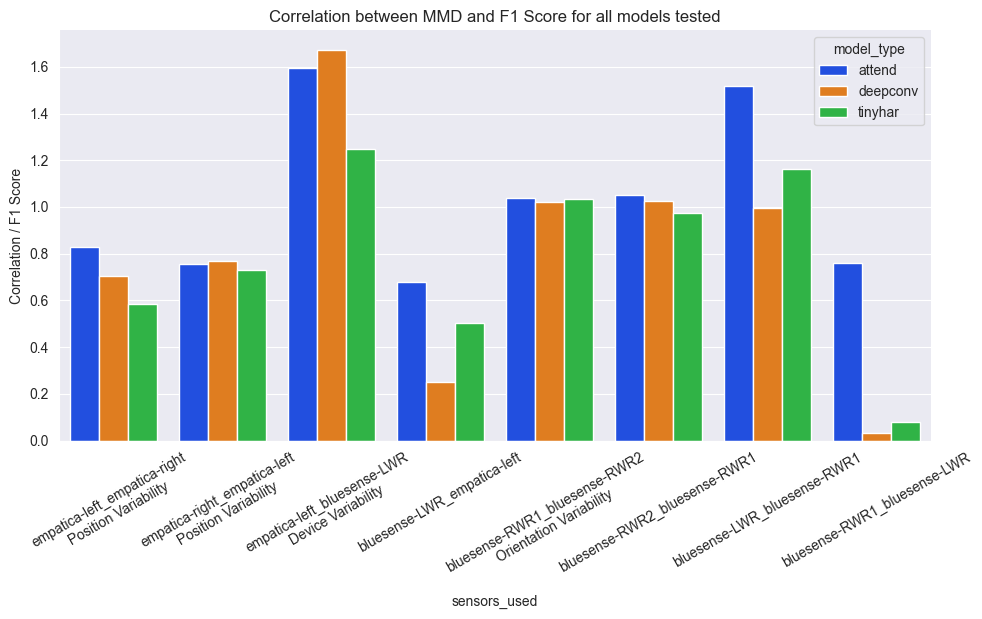

In [16]:
# make all corelation values positive
corr_final_df['correlation'] = corr_final_df['correlation'].abs()
sns.catplot(x='sensors_used', y='correlation', hue='model_type', data=corr_final_df, kind='bar', aspect=2, height=5,
            palette='bright',
            legend_out=False)
# set x labels at 1 30 degree angle
plt.xticks(rotation=30)
plt.ylabel('Correlation / F1 Score')
plt.title('Correlation between MMD and F1 Score for all models tested')


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


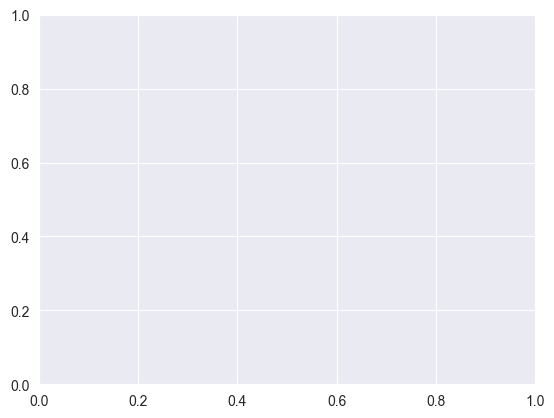

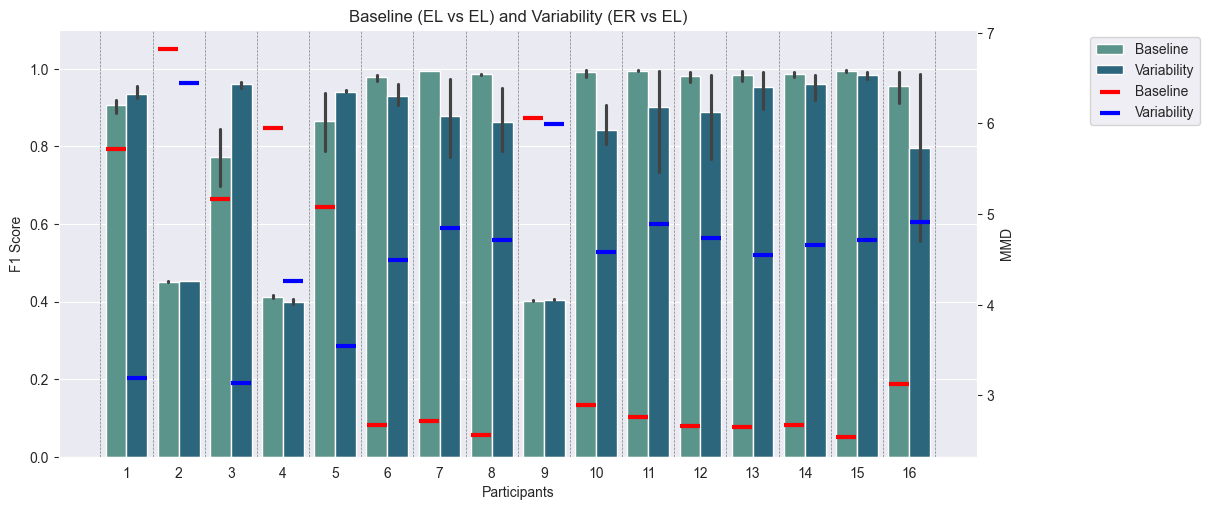

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


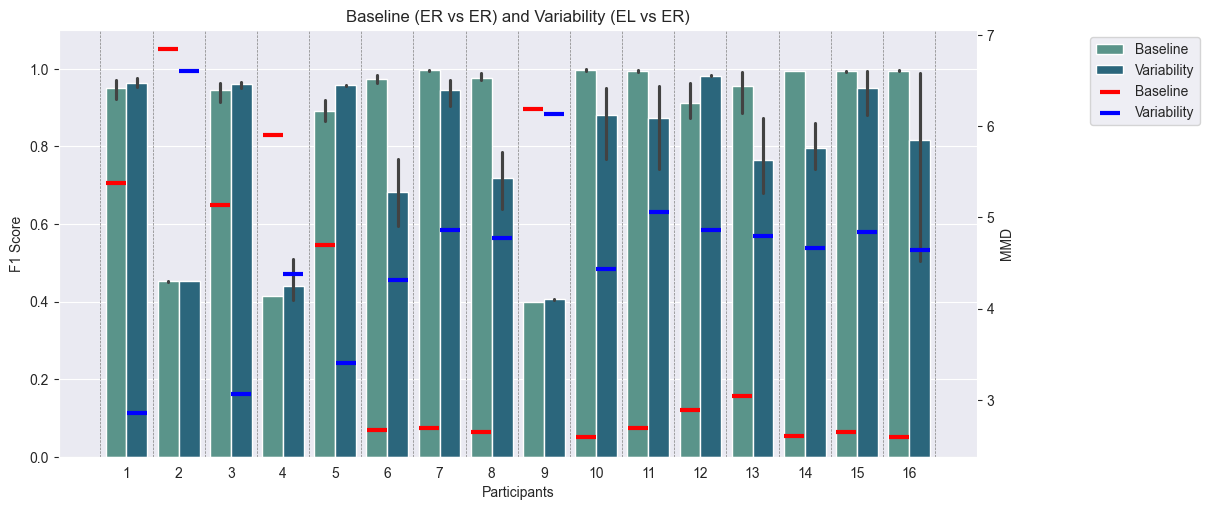

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


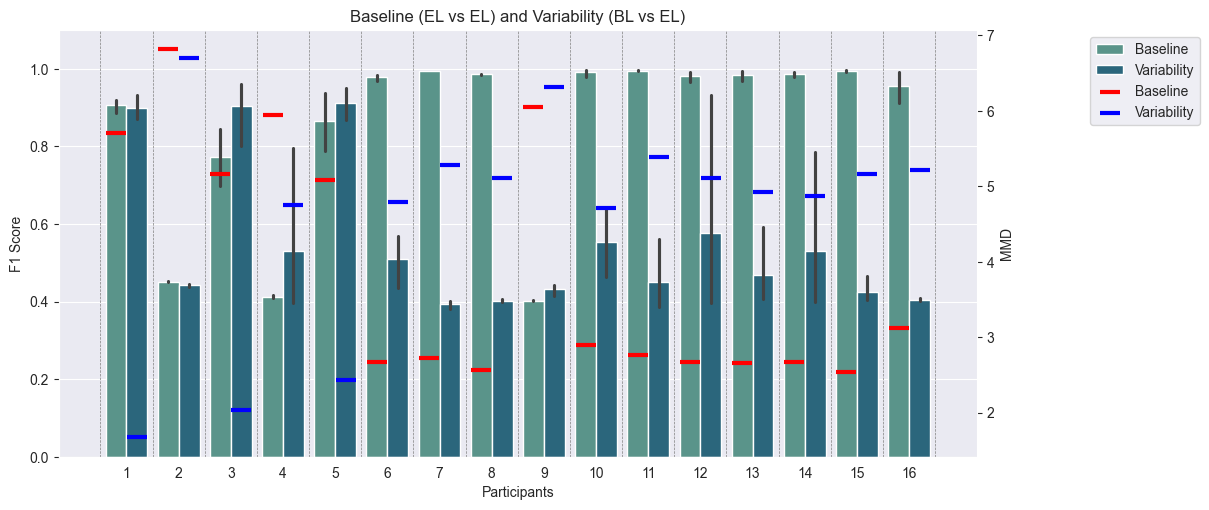

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


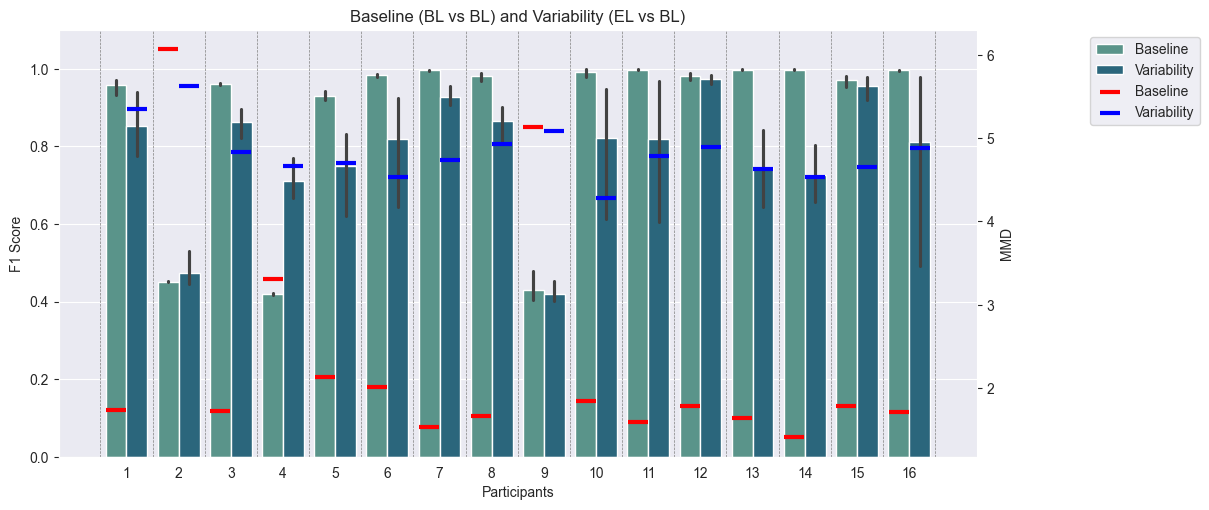

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


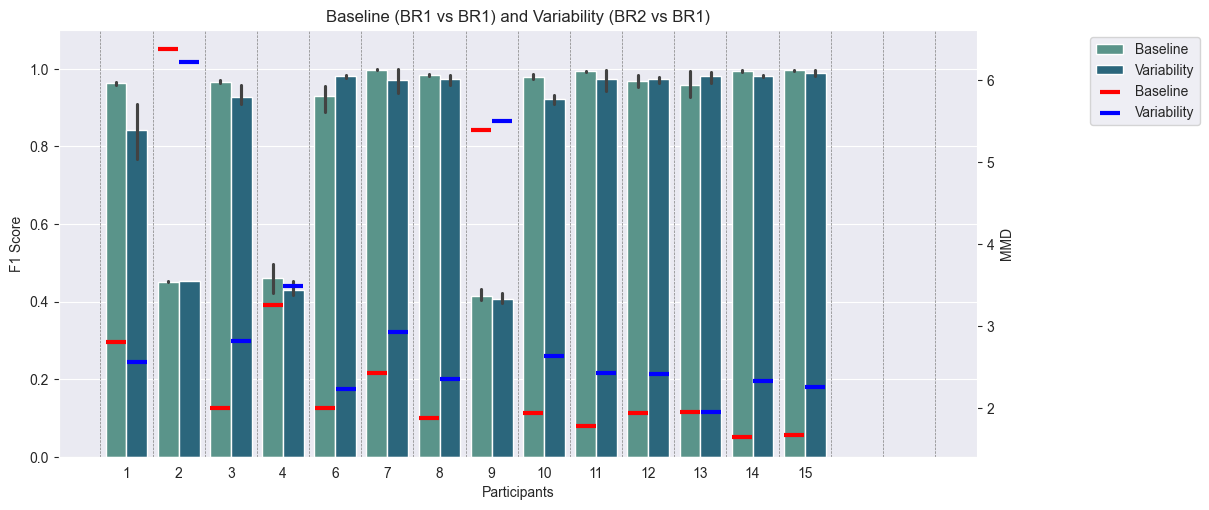

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


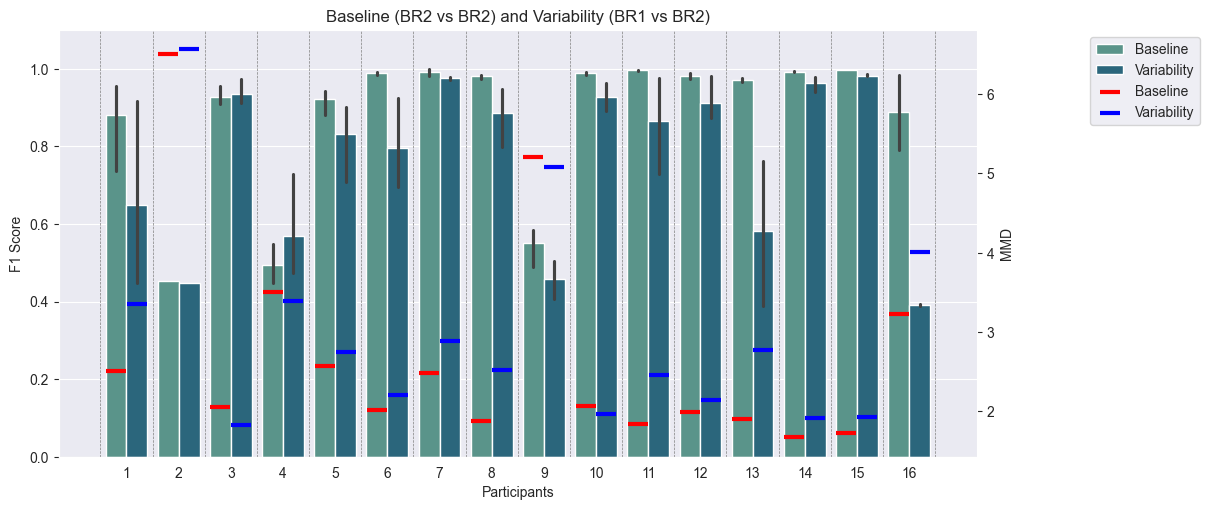

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


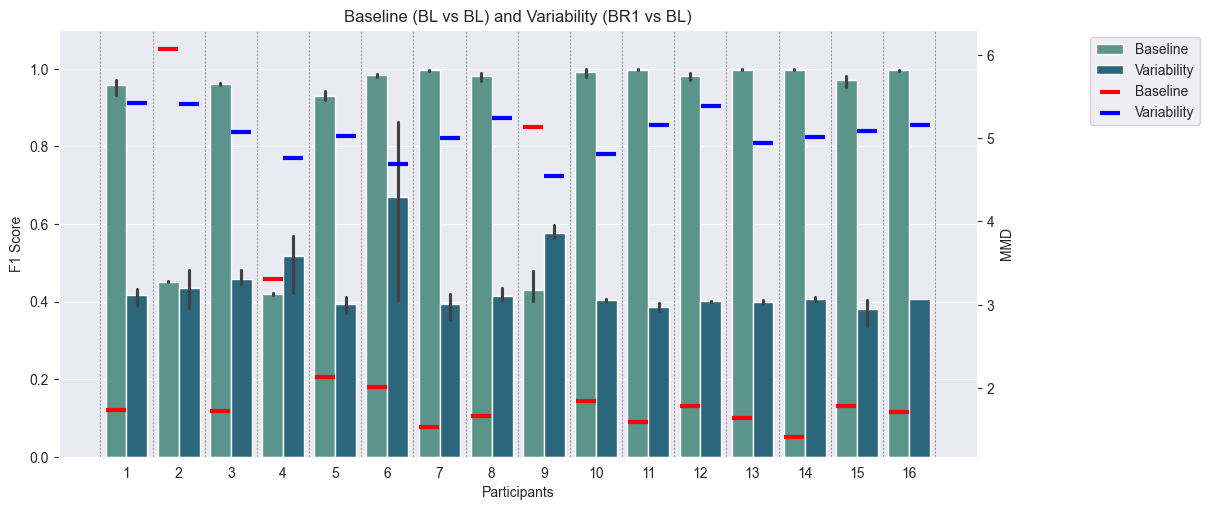

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


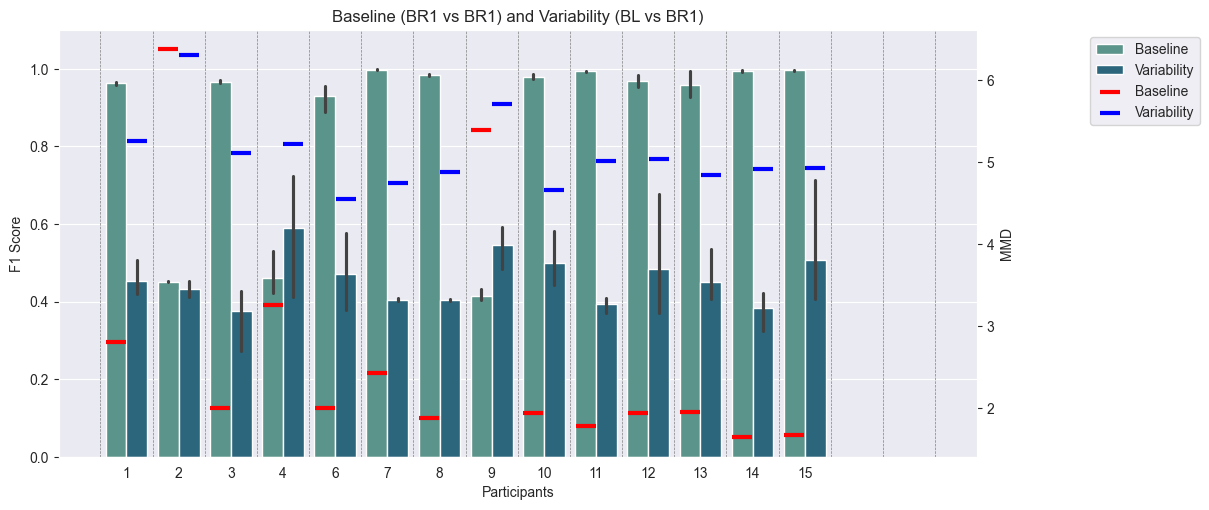

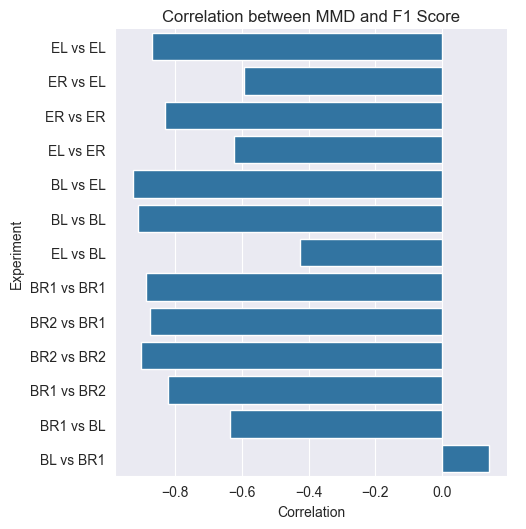

In [17]:
sns.color_palette("crest", as_cmap=True)
# 17 for real disp
num_participants = 16

corr_data = {}
all_data = pd.DataFrame()
# add columns to all_data, activity, device_config, model_type, f1, cv, mmd
all_data['activity'] = 0
all_data['device_config'] = ''
all_data['model_type'] = ''
all_data['f1'] = 0.0
all_data['cv'] = 0
all_data['mmd'] = 0.0

#create empty plot
MMD_F1_plot_ax = plt.gca()

for pair in sensor_list:
    sensor_test = pair[0]
    sensor_train = pair[1]
    result_list = []

    for i in range(num_participants):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            # plot the confusion matrix for each cv
            # create_confusion(root_path, sensor_train, sensor_test, model, i)
            # create_confusion(root_path, sensor_test, sensor_test, model, i)
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break
            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[
                                sensor_test], 'easy_text': 'Baseline',
                            'model_type': model}
            result_list.append(dict_results)
            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[
                                sensor_test], 'easy_text': 'Variability',
                            'model_type': model}
            result_list.append(dict_results)

    df = pd.DataFrame(result_list)
    # all_data = pd.concat([all_data, df], ignore_index=True)

    # plot the f1 score for all participants as bar graph using sns catplot bar with colors red and blue
    ax = sns.catplot(x='cv', y='f1', hue='easy_text', data=df, kind='bar', aspect=2, height=5, palette='crest',
                     legend_out=True)
    ax.legend.remove()
    # remove legend title
    ax._legend.set_title('')
    plt.title(
        'Baseline (' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test] + ')' + ' and Variability (' +
        sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test] + ')')
    plt.xlabel('Participants')
    plt.ylabel('F1 Score')
    # plot max y value is 1.1
    plt.ylim(0, 1.1)

    file_activity = 'using_3d_per_activity'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    '''Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 0]
    mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 0]
    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # if sensor_test is RWR1 then drop cv 17
    if sensor_test == 'bluesense-RWR1':
        # increment CV values greater than 4 by 1
        mmd_1_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_2_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_1_1 = mmd_1_1.drop(mmd_1_1[mmd_1_1['CV'] == 16].index)
        mmd_2_1 = mmd_2_1.drop(mmd_2_1[mmd_2_1['CV'] == 16].index)


    # make the cv column the index
    mmd_1_1 = mmd_1_1.set_index('CV')
    mmd_2_1 = mmd_2_1.set_index('CV')

    # divide the df into two based on device_config
    f1_1_1 = df[(df['device_config'] == 'F1 of ' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test])]
    f1_2_1 = df[(df['device_config'] == 'F1 of ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test])]


    # list of unique cv in mmd_1_1
    cv_list = mmd_1_1.index

    # add the mmd for 1_1 config to all_data
    for i in cv_list:
        for model in ['attend', 'deepconv', 'tinyhar']:
            # get the f1 score for the model and cv from f1_1_1
            f1 = f1_1_1[(f1_1_1['cv'] == i) & (f1_1_1['model_type'] == model)]['f1'].iloc[0]
            new_row = {'activity': 0, 'device_config': sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test],
                       'model_type': model, 'f1': f1, 'cv': i, 'mmd': mmd_1_1.loc[i, 'mmd']}
            all_data = pd.concat([all_data, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    # add the mmd for 2_1 config to all_data
    for i in cv_list:
        for model in ['attend', 'deepconv', 'tinyhar']:
            # get the f1 score for the model and cv from f1_2_1
            f1 = f1_2_1[(f1_2_1['cv'] == i) & (f1_2_1['model_type'] == model)]['f1'].iloc[0]
            new_row = {'activity': 0, 'device_config': sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test],
                       'model_type': model, 'f1': f1, 'cv': i, 'mmd': mmd_2_1.loc[i, 'mmd']}
            all_data = pd.concat([all_data, pd.DataFrame(new_row, index=[0])], ignore_index=True)


    # drop model_type
    f1_1_1 = f1_1_1.drop(columns=['model_type', 'device_config', 'easy_text'])
    f1_2_1 = f1_2_1.drop(columns=['model_type', 'device_config', 'easy_text'])

    # get the mean of all models for each cv
    f1_1_1 = f1_1_1.groupby('cv').mean()
    f1_2_1 = f1_2_1.groupby('cv').mean()



    # finding the corelation between mmd and f1 score for 1_1
    mmd_1_1['f1'] = f1_1_1['f1']
    mmd_2_1['f1'] = f1_2_1['f1']

    # #plot the mmd and f1 on the MMD_F1_plot_ax with color from color pallette 'tab10'
    # sns.scatterplot(data=mmd_1_1, x='f1', y='mmd', palette='tab10', ax=MMD_F1_plot_ax)
    # # add nuber of cv above the points
    # for i in range(len(mmd_1_1)):
    #     MMD_F1_plot_ax.text(mmd_1_1['f1'][i+1], mmd_1_1['mmd'][i+1], mmd_1_1.index[i], fontsize=8)
    #
    # # color pallette 'crest' for 2_1
    # sns.scatterplot(data=mmd_2_1, x='f1', y='mmd', palette='crest', ax=MMD_F1_plot_ax)
    # # add nuber of cv above the points
    # for i in range(len(mmd_2_1)):
    #     MMD_F1_plot_ax.text(mmd_2_1['f1'][i+1], mmd_2_1['mmd'][i+1], mmd_2_1.index[i], fontsize=8)


    # corelation between mmd and f1 score for 1_1
    corr = mmd_1_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test]] = corr['mmd']['f1']

    corr = mmd_2_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test]] = corr['mmd']['f1']

    # divide MMD value by 10
    mmd_1_1['mmd'] = mmd_1_1['mmd']
    mmd_2_1['mmd'] = mmd_2_1['mmd']

    # reset the index to be 0 to len
    mmd_1_1 = mmd_1_1.reset_index()
    mmd_2_1 = mmd_2_1.reset_index()

    # change the index to be -0.25 to its current value
    mmd_1_1.index = mmd_1_1.index - 0.2
    mmd_2_1.index = mmd_2_1.index + 0.2

    # create a twin axis for ax
    ax = plt.gca()
    ax2 = ax.twinx()
    # dont show grid lines for y axis for ax2
    ax2.grid(False)

    # Draw vertical grey lines from 0.5 to 16.5 with an interval of 1
    for i in range(0, 17):
        plt.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.5)

    # plot the mmd values not only as line but also as points on the graph
    sns.scatterplot(data=mmd_1_1['mmd'], color='red',
                    label='Baseline', marker="_", s=200, linewidth=3, ax=ax2)
    sns.scatterplot(data=mmd_2_1['mmd'], color='blue',
                    label='Variability', marker="_", s=200, linewidth=3, ax=ax2)
    ax2.set_ylabel('MMD')
    # join the legend of scatter plot to the legend of the bar plot
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='upper right', bbox_to_anchor=(1.25, 1))
    # remove duplicate legends
    ax2.get_legend().remove()

    if sensor_test == 'empatica-left' and sensor_train == 'empatica-right':
        plt.savefig('mmd_example.png', dpi=300)
    plt.show()

# plot the correlation data
sns.catplot(y=list(corr_data.keys()), x=list(corr_data.values()), kind='bar')
plt.title('Correlation between MMD and F1 Score')
plt.ylabel('Experiment')
plt.xlabel('Correlation')
plt.show()

MMD_F1_plot_ax.set_ylabel('F1 Score')
MMD_F1_plot_ax.set_xlabel('MMD')
MMD_F1_plot_ax.set_title('MMD vs F1 Score')
plt.show()



[ 4.90219217 -0.92012779]


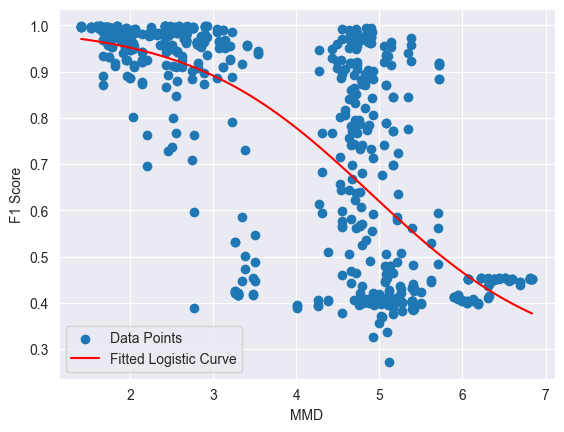

In [18]:
x_data = all_data['mmd']
# convert to numpy array
x_data = np.array(x_data)
y_data = all_data['f1']
# convert to numpy array
y_data = np.array(y_data)
# normalise between 1 and 0
y_data = (y_data - min(y_data)) / (max(y_data) - min(y_data))


def logistic_function(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))


# Fit the logistic curve to the data
popt, _ = curve_fit(logistic_function, x_data, y_data, p0=[np.median(x_data), 1])

# Extract the optimal parameters
x0, k = popt
print(popt)

# L, x0, k = [0.99, 4.53182936, -2.5394542]
# Generate fitted curve data
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = logistic_function(x_fit, x0, k)

# convert y_fit and y_data to be between all_data['f1'].max and all_data['f1'].min
y_fit = y_fit * (max(all_data['f1']) - min(all_data['f1'])) + min(all_data['f1'])
y_data = y_data * (max(all_data['f1']) - min(all_data['f1'])) + min(all_data['f1'])


# Plot the data points and the fitted curve
plt.scatter(x_data, y_data, label='Data Points')
plt.plot(x_fit, y_fit, color='red', label='Fitted Logistic Curve')
plt.xlabel('MMD')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

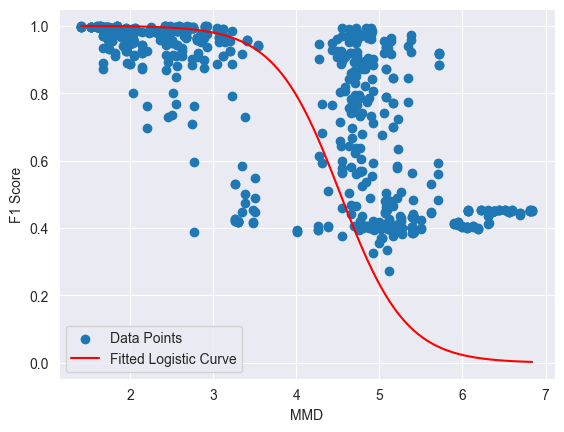

In [19]:
L, x0, k = [0.99, 4.53182936, -2.5394542]
# Generate fitted curve data
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = logistic_function(x_fit, x0, k)

# # convert y_fit and y_data to be between all_data['f1'].max and all_data['f1'].min
# y_fit = y_fit * (max(all_data['f1']) - min(all_data['f1'])) + min(all_data['f1'])
# y_data = y_data * (max(all_data['f1']) - min(all_data['f1'])) + min(all_data['f1'])


# Plot the data points and the fitted curve
plt.scatter(x_data, y_data, label='Data Points')
plt.plot(x_fit, y_fit, color='red', label='Fitted Logistic Curve')
plt.xlabel('MMD')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
emaptica_only_config = [['empatica-left', 'empatica-left'], ['empatica-right', 'empatica-right'],
                        ['empatica-left', 'empatica-right'], ['empatica-right', 'empatica-left']]
bluesense_only_config = [['bluesense-LWR', 'bluesense-LWR'], ['bluesense-RWR1', 'bluesense-RWR1'],
                         ['bluesense-LWR', 'bluesense-RWR1'], ['bluesense-RWR1', 'bluesense-LWR']]

def logistic_function(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

import torch
import torch.nn as nn
import torch.optim as optim

# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # One input feature, one output

    def forward(self, x):
        return torch.sigmoid(self.linear(x))



MSE: 0.24255466950647103


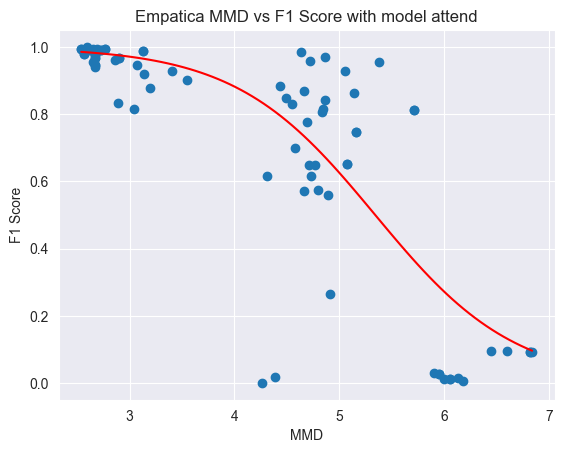

MSE: 0.2321471500918359


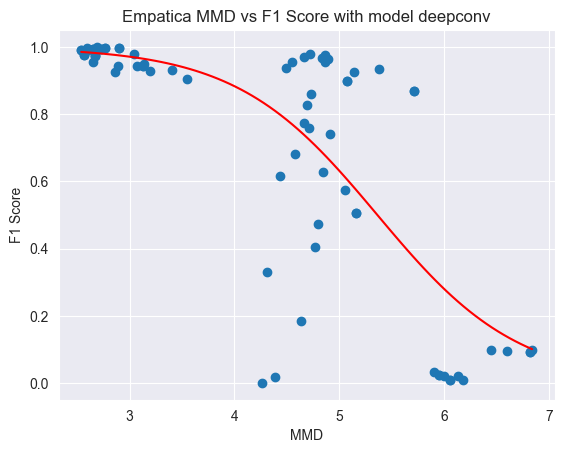

MSE: 0.2456882166794503


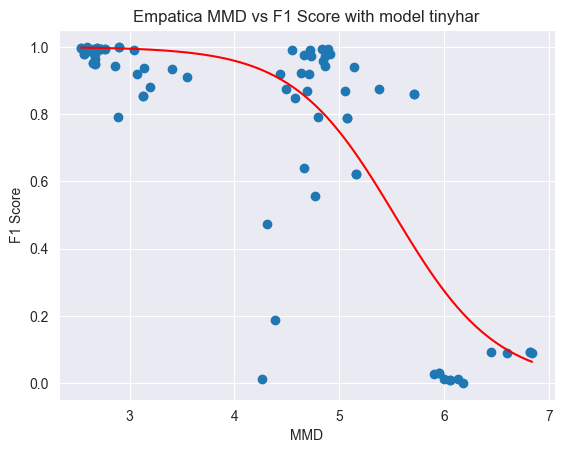

In [21]:
# extract only the emaptica data from all_data
empatica_data = all_data[all_data['device_config'].str.contains('E')]
# remove any config with bluesense
empatica_data = empatica_data[~empatica_data['device_config'].str.contains('B')]

for model in ['attend', 'deepconv', 'tinyhar']:
    data_to_use = empatica_data[empatica_data['model_type'] == model]
    # get x data and y data
    x_data = data_to_use['mmd']
    x_data = np.array(x_data)
    y_data = data_to_use['f1']
    y_data = np.array(y_data)

    # normalise between 1 and 0
    y_data = ((y_data - min(y_data)) / (max(y_data) - min(y_data)))

    # Instantiate the model
    model_log = LogisticRegressionModel()
    X = torch.tensor(x_data).float().view(-1, 1)
    y = torch.tensor(y_data).float().view(-1, 1)

    # Define loss function (Mean Squared Error)
    criterion = nn.MSELoss()

    # Define the optimizer (Stochastic Gradient Descent)
    optimizer = optim.SGD(model_log.parameters(), lr=0.1)

    # Training loop
    num_epochs = 50000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted y by passing X to the model
        y_pred = model_log(X)

        # Compute and print loss
        loss = criterion(y_pred, y)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the parameters

        # if (epoch+1) % 100 == 0:  # Print loss every 100 epochs
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Generate fitted curve data
    x_fit = np.linspace(min(x_data), max(x_data), 80)
    y_fit = model_log(torch.tensor(x_fit).float().view(-1, 1)).detach().numpy()

    # print the MSE
    print('MSE:', mean_squared_error(y_data, y_fit))

    plt.plot(x_fit, y_fit, color='red', label='Fitted Logistic Curve')

    # plot as scatter plot
    plt.scatter(x_data, y_data)

    plt.xlabel('MMD')
    plt.ylabel('F1 Score')
    plt.title('Empatica MMD vs F1 Score with model ' + model)
    plt.show()


Epoch [1000/5000], Loss: 0.0218
Epoch [2000/5000], Loss: 0.0209
Epoch [3000/5000], Loss: 0.0208
Epoch [4000/5000], Loss: 0.0208
Epoch [5000/5000], Loss: 0.0208
MSE: 0.1938996743448831


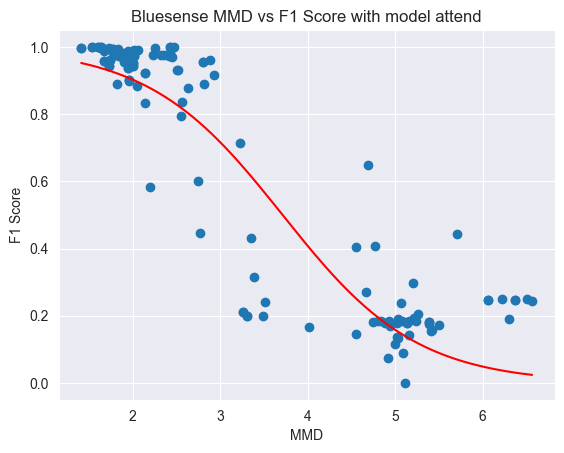

Epoch [1000/5000], Loss: 0.0270
Epoch [2000/5000], Loss: 0.0254
Epoch [3000/5000], Loss: 0.0251
Epoch [4000/5000], Loss: 0.0250
Epoch [5000/5000], Loss: 0.0249
MSE: 0.24893864782436978


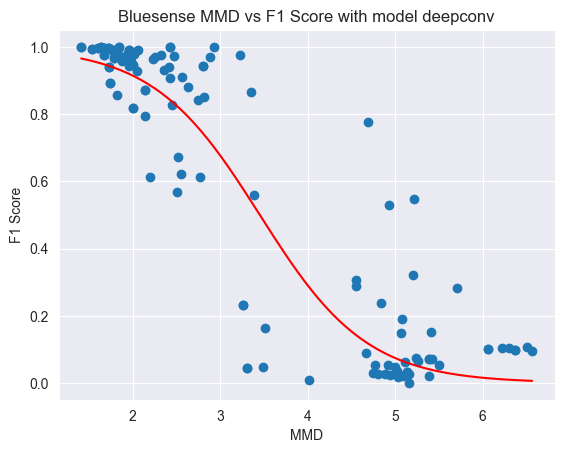

Epoch [1000/5000], Loss: 0.0276
Epoch [2000/5000], Loss: 0.0254
Epoch [3000/5000], Loss: 0.0246
Epoch [4000/5000], Loss: 0.0241
Epoch [5000/5000], Loss: 0.0237
MSE: 0.2758660601403289


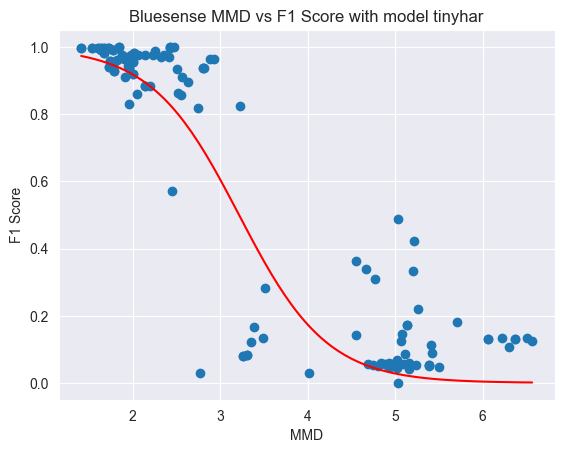

In [22]:


# extract only the bluesense data from all_data
bluesense_data = all_data[all_data['device_config'].str.contains('B')]
# remove any config with emaptica
bluesense_data = bluesense_data[~bluesense_data['device_config'].str.contains('E')]
for model in ['attend', 'deepconv', 'tinyhar']:
    data_to_use = bluesense_data[bluesense_data['model_type'] == model]
    # get x data and y data
    x_data = data_to_use['mmd']
    x_data = np.array(x_data)
    y_data = data_to_use['f1']
    y_data = np.array(y_data)

    # normalise between 100 and 0
    y_data = ((y_data - min(y_data)) / (max(y_data) - min(y_data)))

    # Instantiate the model
    model_log = LogisticRegressionModel()
    X = torch.tensor(x_data).float().view(-1, 1)
    y = torch.tensor(y_data).float().view(-1, 1)

    # Define loss function (Mean Squared Error)
    criterion = nn.MSELoss()

    # Define the optimizer (Stochastic Gradient Descent)
    optimizer = optim.SGD(model_log.parameters(), lr=0.3)

    # Training loop
    num_epochs = 5000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted y by passing X to the model
        y_pred = model_log(X)

        # Compute and print loss
        loss = criterion(y_pred, y)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the parameters

        if (epoch+1) % 1000 == 0:  # Print loss every 100 epochs
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Generate fitted curve data
    x_fit = np.linspace(min(x_data), max(x_data), 136)
    y_fit = model_log(torch.tensor(x_fit).float().view(-1, 1)).detach().numpy()

    # print the MSE
    print('MSE:', mean_squared_error(y_data, y_fit))

    plt.plot(x_fit, y_fit, color='red', label='Fitted Logistic Curve')

    # plot as scatter plot
    plt.scatter(x_data, y_data)

    plt.xlabel('MMD')
    plt.ylabel('F1 Score')
    plt.title('Bluesense MMD vs F1 Score with model ' + model)
    plt.show()


[ 3.71133784 -1.30599893]
MSE: 0.19432856029698817


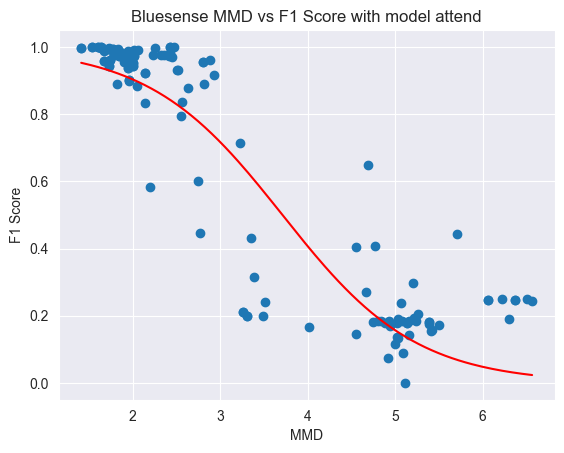

[ 3.41399726 -1.75956246]
MSE: 0.2580280508284795


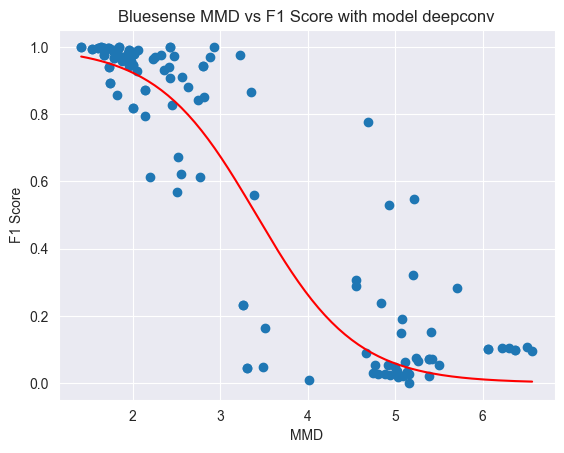

[ 3.0746953  -4.39272274]
MSE: 0.3353315508422065


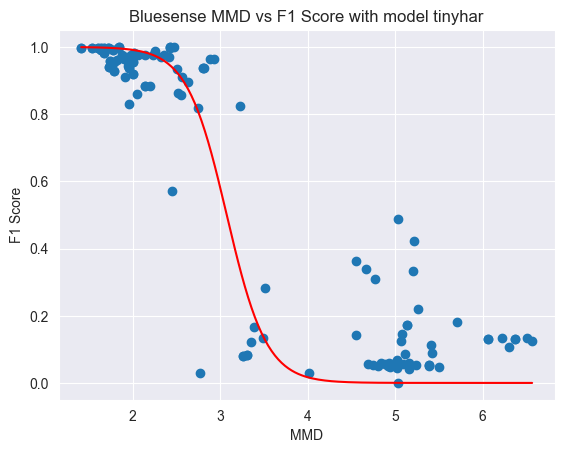

In [23]:


# extract only the bluesense data from all_data
bluesense_data = all_data[all_data['device_config'].str.contains('B')]
# remove any config with emaptica
bluesense_data = bluesense_data[~bluesense_data['device_config'].str.contains('E')]
for model in ['attend', 'deepconv', 'tinyhar']:
    data_to_use = bluesense_data[bluesense_data['model_type'] == model]
    # get x data and y data
    x_data = data_to_use['mmd']
    x_data = np.array(x_data)
    y_data = data_to_use['f1']
    y_data = np.array(y_data)

    # normalise between 100 and 0
    y_data = ((y_data - min(y_data)) / (max(y_data) - min(y_data)))

    # # process the data using standardization
    # x_data = (x_data - x_data.mean()) / x_data.std()

    # Fit the logistic curve to the data
    popt, _ = curve_fit(logistic_function, x_data, y_data, p0=[np.median(x_data), 1])

    # Extract the optimal parameters
    x0, k = popt
    print(popt)

    # L, x0, k = [0.99, 4.53182936, -2.5394542]
    # Generate fitted curve data
    x_fit = np.linspace(min(x_data), max(x_data), 136)
    y_fit = logistic_function(x_fit,x0, k)

    # print the MSE
    print('MSE:', mean_squared_error(y_data, y_fit))

    plt.plot(x_fit, y_fit, color='red', label='Fitted Logistic Curve')

    # plot as scatter plot
    plt.scatter(x_data, y_data)
    plt.xlabel('MMD')
    plt.ylabel('F1 Score')
    plt.title('Bluesense MMD vs F1 Score with model ' + model)
    plt.show()


Fitted parameters: [ 0.84839     0.24282789  0.67866874 -4.6396294 ]


RMSE: 0.1615743262234
R-squared: 0.5700218471012861



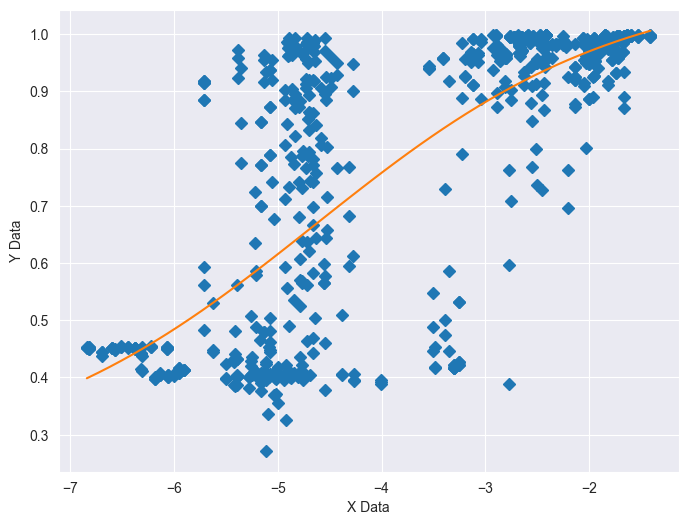

In [24]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

x_data = -all_data['mmd']
# convert to numpy array
xData = np.array(x_data)
y_data = all_data['f1']
# convert to numpy array
yData = np.array(y_data)


def func(x, a, b, c, d):
    return a / (1.0 + numpy.exp(-c * (x - d))) + b


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore")  # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    parameterBounds = []
    parameterBounds.append([0.0, 100.0])  # search bounds for a
    parameterBounds.append([-10.0, 0.0])  # search bounds for b
    parameterBounds.append([0.0, 10.0])  # search bounds for c
    parameterBounds.append([0.0, 10.0])  # search bounds for d

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x


# by default, differential_evolution completes by calling curve_fit() using parameter bounds
geneticParameters = generate_Initial_Parameters()

# now call curve_fit without passing bounds from the genetic algorithm,
# just in case the best fit parameters are aoutside those bounds
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
print('Fitted parameters:', fittedParameters)
print()

modelPredictions = func(xData, *fittedParameters)

absError = modelPredictions - yData

SE = numpy.square(absError)  # squared errors
MSE = numpy.mean(SE)  # mean squared errors
RMSE = numpy.sqrt(MSE)  # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

print()
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

print()


##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth / 100.0, graphHeight / 100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData, 'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data')  # X axis data label
    axes.set_ylabel('Y Data')  # Y axis data label

    plt.show()
    plt.close('all')  # clean up after using pyplot


graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

In [25]:
noise_clean = False

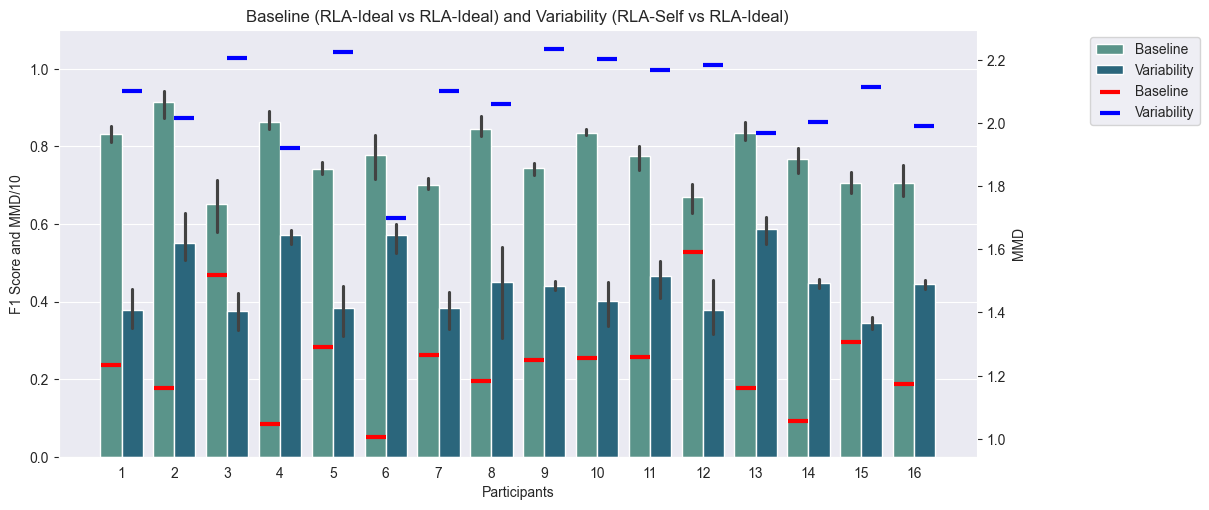

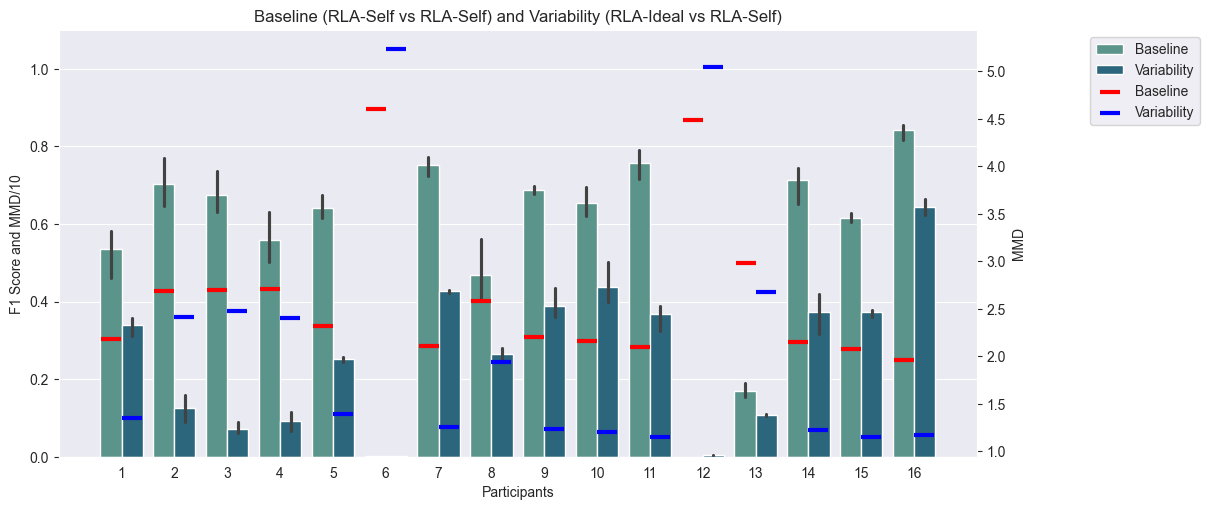

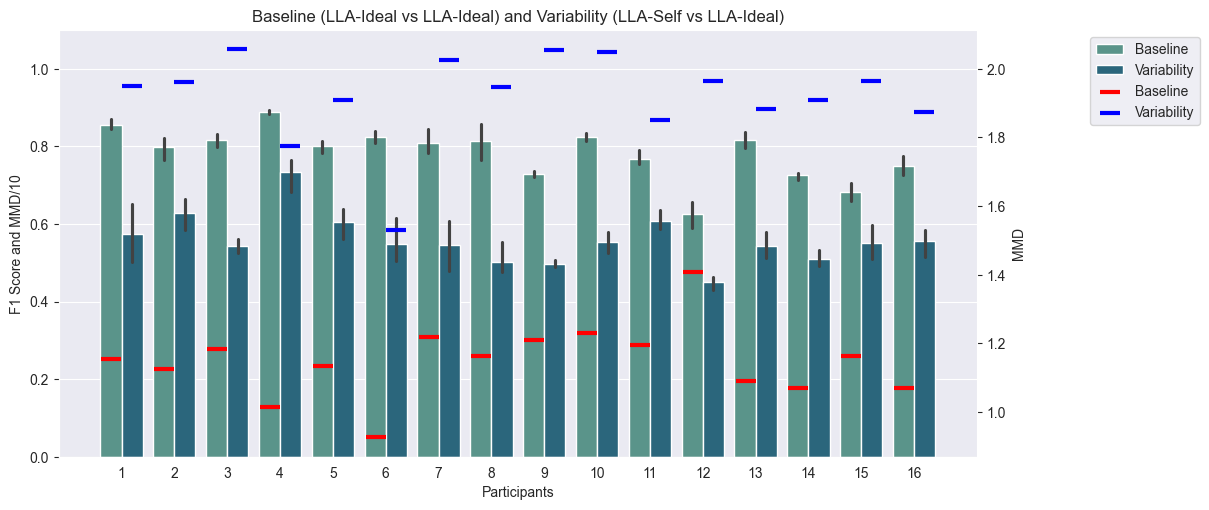

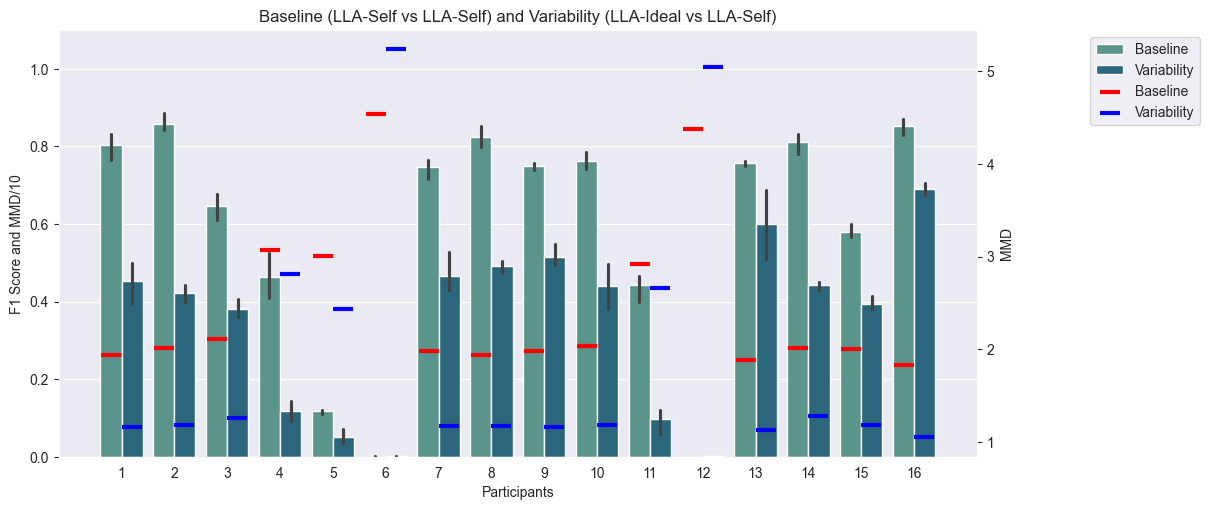

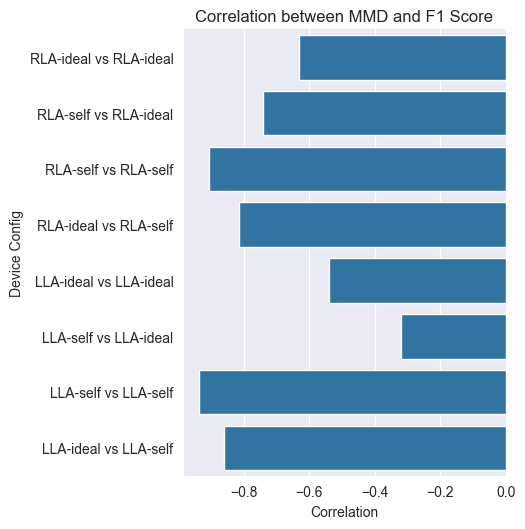

In [26]:
sns.color_palette("crest", as_cmap=True)

corr_data = {}

for pair in sensor_list_realdisp:
    sensor_test = pair[0]
    sensor_train = pair[1]
    result_list = []

    var_type = check_var(sensor_test, sensor_train)

    for i in range(num_participants_realdisp):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            # plot the confusion matrix for each cv
            # create_confusion(root_path, sensor_train, sensor_test, model, i)
            # create_confusion(root_path, sensor_test, sensor_test, model, i)
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break
            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[
                                sensor_test], 'easy_text': 'Baseline',
                            'model_type': model}
            result_list.append(dict_results)
            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[
                                sensor_test], 'easy_text': 'Variability',
                            'model_type': model}
            result_list.append(dict_results)

    df = pd.DataFrame(result_list)

    # plot the f1 score for all participants as bar graph using sns catplot bar with colors red and blue
    ax = sns.catplot(x='cv', y='f1', hue='easy_text', data=df, kind='bar', aspect=2, height=5, palette='crest',
                     legend_out=True)
    ax.legend.remove()
    # remove legend title
    ax._legend.set_title('')
    plt.title(
        'Baseline (' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test] + ')' + ' and Variability (' +
        sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test] + ')')
    plt.xlabel('Participants')
    plt.ylabel('F1 Score and MMD/10')
    # plot max y value is 1.1
    plt.ylim(0, 1.1)

    file_activity = 'using_3d_per_activity'

    if noise_clean:
        file_activity = 'using_3d_per_activity/no_noise'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    # '''Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    # mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 1]
    # mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 1]

    ''' Get the mean for all activities for each cv '''
    mmd_1_1 = mmd_1_1.groupby('CV').mean()
    mmd_2_1 = mmd_2_1.groupby('CV').mean()

    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # divide the df into two based on device_config
    f1_1_1 = df[(df['device_config'] == 'F1 of ' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test])]
    f1_2_1 = df[(df['device_config'] == 'F1 of ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test])]
    # drop model_type
    f1_1_1 = f1_1_1.drop(columns='model_type')
    f1_2_1 = f1_2_1.drop(columns='model_type')
    # drop device_config
    f1_1_1 = f1_1_1.drop(columns=['device_config', 'easy_text'])
    f1_2_1 = f1_2_1.drop(columns=['device_config', 'easy_text'])

    # get the mean of all models for each cv
    f1_1_1 = f1_1_1.groupby('cv').mean()
    f1_2_1 = f1_2_1.groupby('cv').mean()

    # make the cv column the index
    mmd_1_1 = mmd_1_1.set_index('CV')
    mmd_2_1 = mmd_2_1.set_index('CV')

    # finding the corelation between mmd and f1 score for 1_1
    mmd_1_1['f1'] = f1_1_1['f1']
    mmd_2_1['f1'] = f1_2_1['f1']

    # corelation between mmd and f1 score for 1_1
    corr = mmd_1_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_test + ' vs ' + sensor_test] = corr['mmd']['f1']

    corr = mmd_2_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_train + ' vs ' + sensor_test] = corr['mmd']['f1']

    # divide MMD value by 10
    mmd_1_1['mmd'] = mmd_1_1['mmd']
    mmd_2_1['mmd'] = mmd_2_1['mmd']

    # reset the index to be 0 to len
    mmd_1_1 = mmd_1_1.reset_index()
    mmd_2_1 = mmd_2_1.reset_index()

    # change the index to be -0.25 to its current value
    # change the index to be -0.25 to its current value
    mmd_1_1.index = mmd_1_1.index - 0.19
    mmd_2_1.index = mmd_2_1.index + 0.19

    # create a twin axis for ax
    ax = plt.gca()
    ax2 = ax.twinx()
    # dont show grid lines
    ax2.grid(False)
    # plot the mmd values not only as line but also as points on the graph
    sns.scatterplot(data=mmd_1_1['mmd'], color='red',
                    label='Baseline', marker="_", s=200, linewidth=3, ax=ax2)
    sns.scatterplot(data=mmd_2_1['mmd'], color='blue',
                    label='Variability', marker="_", s=200, linewidth=3, ax=ax2)
    ax2.set_ylabel('MMD')
    # join the legend of scatter plot to the legend of the bar plot
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='upper right', bbox_to_anchor=(1.25, 1))
    # remove duplicate legends
    ax2.get_legend().remove()

    if sensor_test == 'empatica-left' and sensor_train == 'empatica-right':
        plt.savefig('mmd_example.png', dpi=300)
    plt.show()

# plot the correlation data
sns.catplot(y=list(corr_data.keys()), x=list(corr_data.values()), kind='bar')
plt.title('Correlation between MMD and F1 Score')
plt.ylabel('Device Config')
plt.xlabel('Correlation')
plt.show()

In [56]:
corr_data = {}
df = pd.DataFrame()
all_data = pd.DataFrame()
all_data['device_config'] = ''
all_data['model_type'] = ''
all_data['mmd'] = 0.0
all_data['f1'] = 0.0
all_data['cv'] = 0
for pair in sensor_list_realdisp:
    sensor_test = pair[0]
    sensor_train = pair[1]
    var_type = check_var(sensor_test, sensor_train)
    result_list = []

    for i in range(num_participants_realdisp):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            # plot the confusion matrix for each cv
            # create_confusion(root_path, sensor_train, sensor_test, model, i)
            # create_confusion(root_path, sensor_test, sensor_test, model, i)
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i, noise_clean)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i, noise_clean)

            if result1 == None or result2 == None:
                break

            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test, 'model_type': model,
                            'var_type': var_type, 'has_var': False}
            result_list.append(dict_results)
            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_train + ' vs ' + sensor_test, 'model_type': model,
                            'var_type': var_type, 'has_var': True}
            result_list.append(dict_results)

    df = pd.concat([df, pd.DataFrame(result_list)], ignore_index=True)

    file_activity = 'using_3d_per_activity'
    if noise_clean:
        file_activity = 'using_3d_per_activity/no_noise'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    # '''Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    # mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 0]
    # mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 0]


    '''' Get the mean for all activities for each cv '''
    mmd_1_1 = mmd_1_1.groupby('CV').mean()
    mmd_2_1 = mmd_2_1.groupby('CV').mean()

    #add all the 1_1 data to all data
    for i in mmd_1_1.index:
        for model in ['attend', 'deepconv', 'tinyhar']:
            # add the data to all_data using concat
            all_data = pd.concat([all_data, pd.DataFrame({'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test,
                                                          'model_type': model,
                                                          'mmd': mmd_1_1['mmd'][i],
                                                          'f1': df[(df['device_config'] == 'F1 of ' + sensor_test + ' vs ' + sensor_test) & (df['cv'] == i) & (df['model_type'] == model)]['f1'],
                                                          'cv': i})], ignore_index=True)

    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # if sensor_test is RWR1 then drop cv 17
    if sensor_test == 'bluesense-RWR1':
        # increment CV values greater than 4 by 1
        mmd_1_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_2_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_1_1 = mmd_1_1.drop(mmd_1_1[mmd_1_1['CV'] == 16].index)
        mmd_2_1 = mmd_2_1.drop(mmd_2_1[mmd_2_1['CV'] == 16].index)

    # divide the df into two based on device_config
    f1_1_1 = df[(df['device_config'] == 'F1 of ' + sensor_test + ' vs ' + sensor_test)]
    f1_2_1 = df[(df['device_config'] == 'F1 of ' + sensor_train + ' vs ' + sensor_test)]
    # drop
    f1_1_1 = f1_1_1.drop(columns=['model_type', 'device_config', 'var_type', 'has_var'])
    f1_2_1 = f1_2_1.drop(columns=['model_type', 'device_config', 'var_type', 'has_var'])

    # get the mean of all models for each cv
    f1_1_1 = f1_1_1.groupby('cv').mean()
    f1_2_1 = f1_2_1.groupby('cv').mean()

    # make the cv column the index
    mmd_1_1 = mmd_1_1.set_index('CV')
    mmd_2_1 = mmd_2_1.set_index('CV')

    # finding the corelation between mmd and f1 score for 1_1
    mmd_1_1['f1'] = f1_1_1['f1']
    mmd_2_1['f1'] = f1_2_1['f1']

    # corelation between mmd and f1 score for 1_1
    corr = mmd_1_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_test + ' vs ' + sensor_test] = corr['mmd']['f1']

    corr = mmd_2_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_train + ' vs ' + sensor_test] = corr['mmd']['f1']

    # divide MMD value by 10
    mmd_1_1['mmd'] = mmd_1_1['mmd']
    mmd_2_1['mmd'] = mmd_2_1['mmd']

    # reset the index to be 0 to len
    mmd_1_1 = mmd_1_1.reset_index()
    mmd_2_1 = mmd_2_1.reset_index()

    # reset the index for df
    df = df.reset_index(drop=True)

    # set the mmd values
    for row in mmd_1_1.iterrows():
        row = row[1]
        cv = row['CV']
        mmd = row['mmd']
        df.loc[(df['device_config'] == 'F1 of ' + sensor_test + ' vs ' + sensor_test) & (df['cv'] == cv), 'mmd'] = mmd
    for row in mmd_2_1.iterrows():
        row = row[1]
        cv = row['CV']
        mmd = row['mmd']
        df.loc[(df['device_config'] == 'F1 of ' + sensor_train + ' vs ' + sensor_test) & (df['cv'] == cv), 'mmd'] = mmd

In [57]:
all_data

,device_config,model_type,mmd,f1,cv
0,F1 of RLA-ideal vs RLA-ideal,attend,1.233523,0.810421,1
1,F1 of RLA-ideal vs RLA-ideal,deepconv,1.233523,0.833479,1
2,F1 of RLA-ideal vs RLA-ideal,tinyhar,1.233523,0.851661,1
3,F1 of RLA-ideal vs RLA-ideal,attend,1.162200,0.943374,2
4,F1 of RLA-ideal vs RLA-ideal,deepconv,1.162200,0.923926,2
...,...,...,...,...,...
175,F1 of LLA-self vs LLA-self,deepconv,2.014883,0.573704,15
176,F1 of LLA-self vs LLA-self,tinyhar,2.014883,0.565891,15
177,F1 of LLA-self vs LLA-self,attend,2.004104,0.870804,16
178,F1 of LLA-self vs LLA-self,deepconv,2.004104,0.855340,16


[ 1.20904028 -1.45068101]
MSE: 0.05465568064029325


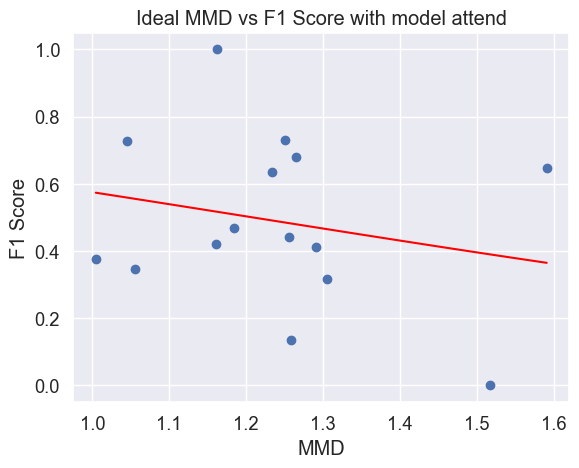

[ 1.20255671 -1.34528425]
MSE: 0.07552744316488426


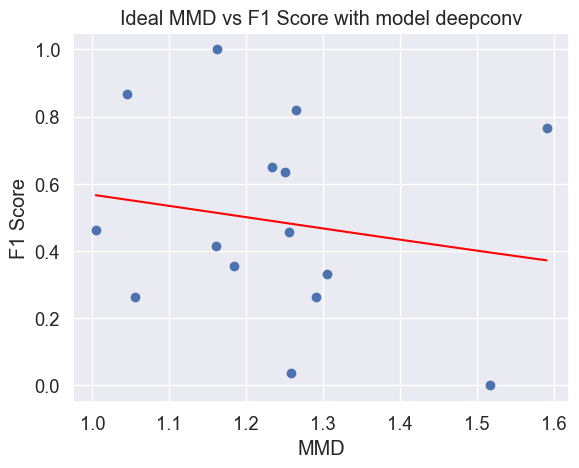

[ 1.37545141 -1.41942146]
MSE: 0.08737172949614903


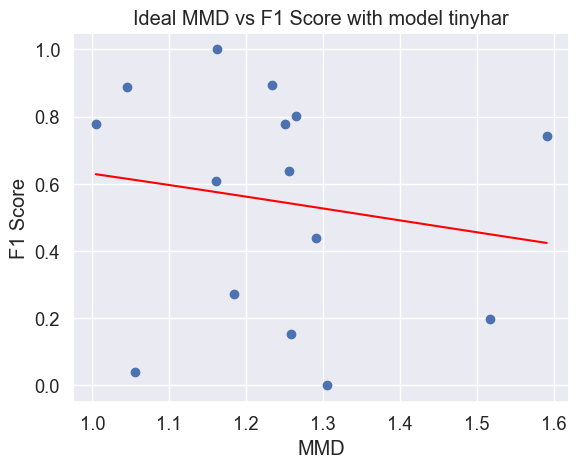

In [63]:
# get the data that has ideal in device config
ideal_data = all_data[all_data['device_config'].str.contains('ideal')]

# get the data that has RLA in device config
rla_data = ideal_data[ideal_data['device_config'].str.contains('RLA')]


for model in ['attend', 'deepconv', 'tinyhar']:
    # x_data is the mmd values
    x_data = rla_data[rla_data['model_type'] == model]['mmd']
    # y_data is the f1 values
    y_data = rla_data[rla_data['model_type'] == model]['f1']

    # normalise between 1 and 0
    y_data = ((y_data - min(y_data)) / (max(y_data) - min(y_data)))

    # fit to a logistic curve
    popt, _ = curve_fit(logistic_function, x_data, y_data, p0=[np.median(x_data), 1])

    # Extract the optimal parameters
    x0, k = popt
    print(popt)

    # Generate fitted curve data
    x_fit = np.linspace(min(x_data), max(x_data), 15)
    y_fit = logistic_function(x_fit, x0, k)

    # print the MSE
    print('MSE:', mean_squared_error(y_data, y_fit))

    plt.plot(x_fit, y_fit, color='red', label='Fitted Logistic Curve')
    plt.scatter(x_data, y_data)
    plt.xlabel('MMD')
    plt.ylabel('F1 Score')
    plt.title('Ideal MMD vs F1 Score with model ' + model)
    plt.show()


In [60]:
# get the average mmd and f1 for each model for each device_config
# use only 'device_config', 'model_type', 'cv', 'f1', 'mmd' columns
df_mean = df[['device_config', 'model_type', 'cv', 'f1', 'mmd']].copy()
df_mean = df_mean.groupby(['device_config', 'model_type']).mean()
df_mean

cv        f1       mmd
device_config                model_type                         
F1 of LLA-ideal vs LLA-ideal attend      8.5  0.777994  1.147276
                             deepconv    8.5  0.791103  1.147276
                             tinyhar     8.5  0.779745  1.147276
F1 of LLA-ideal vs LLA-self  attend      8.5  0.327209  1.945438
                             deepconv    8.5  0.351953  1.945438
                             tinyhar     8.5  0.364885  1.945438
F1 of LLA-self vs LLA-ideal  attend      8.5  0.551756  1.918455
                             deepconv    8.5  0.581073  1.918455
                             tinyhar     8.5  0.544964  1.918455
F1 of LLA-self vs LLA-self   attend      8.5  0.588124  2.478666
                             deepconv    8.5  0.596096  2.478666
                             tinyhar     8.5  0.581319  2.478666
F1 of RLA-ideal vs RLA-ideal attend      8.5  0.754928  1.234603
                             deepconv    8.5  0.785641  1.234603
                             tinyhar     8.5  0.777219  1.234603
F1 of RLA-ideal vs RLA-self  attend      8.5  0.255910  2.081781
                             deepconv    8.5  0.271487  2.081781
                             tinyhar     8.5  0.272074  2.081781
F1 of RLA-self vs RLA-ideal  attend      8.5  0.429812  2.074261
                             deepconv    8.5  0.465547  2.074261
                             tinyhar     8.5  0.451158  2.074261
F1 of RLA-self vs RLA-self   attend      8.5  0.529158  2.624678
                             deepconv    8.5  0.545686  2.624678
                             tinyhar     8.5  0.569757  2.624678

In [29]:
def get_labels_p_values(sensor1, sensor2, results_conf):
    labels = []
    for model in model_list:
        conf = sensor1 + ' vs ' + sensor2
        p_value = results_conf[(results_conf['device_config'] == conf) & (results_conf['model_type'] == model)][
            'f1_p_value'].values[0]
        print(p_value)
        if p_value <= 0.001:
            labels.append('***')
        elif p_value <= 0.01:
            labels.append('**')
        elif p_value <= 0.05:
            labels.append('*')
        else:
            labels.append('')
    print(labels)
    return labels

In [30]:


results_conf = pd.DataFrame(
    columns=['device_config', 'model_type', 'f1_t_test', 'f1_p_value'])

for sensors in sensor_list_realdisp:
    sensor1 = sensors[0]
    sensor2 = sensors[1]
    for model in model_list:
        conf = sensor2 + ' vs ' + sensor1
        # get data from df where sensor conf is s2 s2 and s1 s2 with model type
        data_for_var_per_model = df[((df['device_config'] == 'F1 of ' + sensor2 + ' vs ' + sensor1) |
                                     (df['device_config'] == 'F1 of ' + sensor1 + ' vs ' + sensor1)) & (
                                            df['model_type'] == model)]

        # remove any duplicates
        data_for_var_per_model = data_for_var_per_model.drop_duplicates()

        # get the t-test for the data with has_var and not has_var
        ttest_f1 = ttest_rel(data_for_var_per_model[data_for_var_per_model['has_var'] == False]['f1'],
                             data_for_var_per_model[data_for_var_per_model['has_var'] == True]['f1'])
        results_conf = pd.concat([results_conf, pd.DataFrame(
            {'device_config': conf, 'model_type': model, 'f1_t_test': ttest_f1[0], 'f1_p_value': ttest_f1[1]},
            index=[0])], ignore_index=True)

results_conf

,device_config,model_type,f1_t_test,f1_p_value
0,RLA-self vs RLA-ideal,attend,14.361729,3.580867e-10
1,RLA-self vs RLA-ideal,deepconv,24.113082,2.067594e-13
2,RLA-self vs RLA-ideal,tinyhar,14.483261,3.181050e-10
3,RLA-ideal vs RLA-self,attend,5.946734,2.678867e-05
4,RLA-ideal vs RLA-self,deepconv,5.873889,3.058335e-05
5,RLA-ideal vs RLA-self,tinyhar,6.551932,9.166667e-06
6,LLA-self vs LLA-ideal,attend,10.804255,1.789302e-08
7,LLA-self vs LLA-ideal,deepconv,16.578998,4.688695e-11
8,LLA-self vs LLA-ideal,tinyhar,13.074935,1.326942e-09
9,LLA-ideal vs LLA-self,attend,7.553980,1.732601e-06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.5808667106751944e-10
2.067593983882232e-13
3.181049905969241e-10
['***', '***', '***']


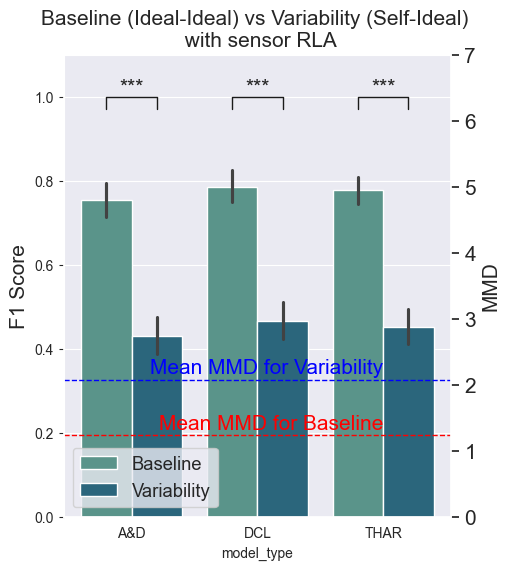

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.678867069529616e-05
3.058335193839131e-05
9.166667455056253e-06
['***', '***', '***']


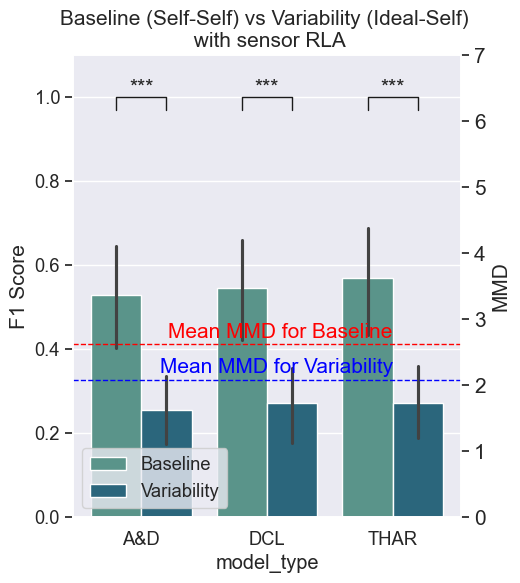

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.7893015794462388e-08
4.68869471728612e-11
1.3269422041197007e-09
['***', '***', '***']


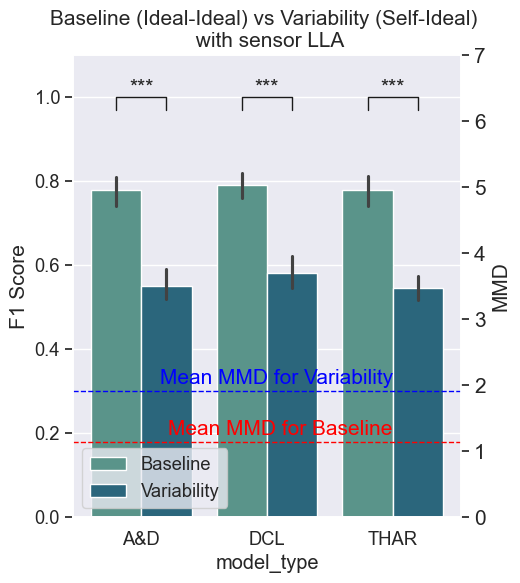

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.7326014257597927e-06
3.728345880137137e-06
1.2619899993176329e-05
['***', '***', '***']


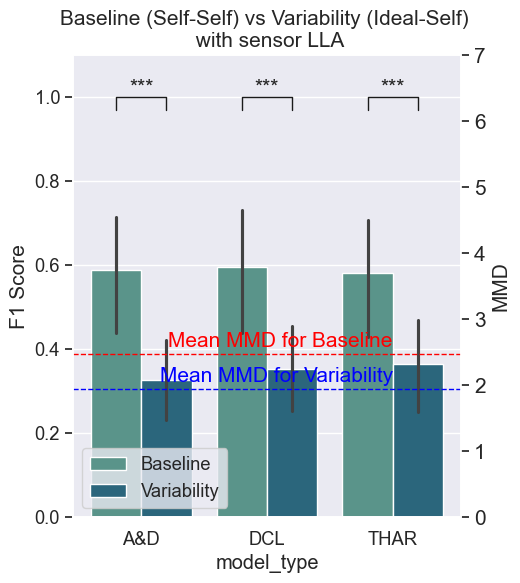

In [31]:
combined_mean_data = pd.DataFrame()
combined_mean_mmd = pd.DataFrame()

for pair in sensor_list_realdisp:
    sensor_test = pair[0]
    sensor_train = pair[1]
    # set the size of the graph to be 5, 9
    plt.figure(figsize=(5, 6))

    # filter out the data for the var type where sensor_test is sensor_test and sensor_train is either sensor test or sensor train
    plot_data = df[((df['device_config'] == 'F1 of ' + sensor_train + ' vs ' + sensor_test) |
                    (df['device_config'] == 'F1 of ' + sensor_test + ' vs ' + sensor_test))]
    # rename the device_config from 'F1 of ' + sensor_train + ' vs ' + sensor_test to 'Train('+sensor_abbriv[sensor_train]+') vs Test('+sensor_abbriv[sensor_test]+')'
    plot_data['device_config'] = plot_data['device_config'].replace('F1 of ' + sensor_train + ' vs ' + sensor_test,
                                                                    'Train(' + sensor_abbrev[
                                                                        sensor_train] + ') vs Test(' +
                                                                    sensor_abbrev[sensor_test] + ')')
    # rename the device_config from 'F1 of ' + sensor_test + ' vs ' + sensor_test to 'Test('+sensor_abbriv[sensor_test]+') vs Test('+sensor_abbriv[sensor_test]+')'
    plot_data['device_config'] = plot_data['device_config'].replace('F1 of ' + sensor_test + ' vs ' + sensor_test,
                                                                    'Train(' + sensor_abbrev[
                                                                        sensor_test] + ') vs Test(' + sensor_abbrev[
                                                                        sensor_test] + ')')

    combined_mean_data = pd.concat([combined_mean_data, plot_data], ignore_index=True)
    ax = sns.barplot(x='model_type', y='f1', hue='device_config', data=plot_data, palette='crest')
    # remove legend
    ax.get_legend().remove()
    # rename the legend for barplot to be Baseline and Variability
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Baseline', 'Variability'], title='')
    # make the legend text size 15
    sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 0))
    sns.set(font_scale=1.2)
    # add the p values to the graph
    labels = get_labels_p_values(sensor_train, sensor_test, results_conf)
    # ax.bar_label(ax.containers[0], labels=labels, fontsize=30)
    init_val = 0
    diff_val = 0.2
    for label in labels:
        plt.plot([init_val - diff_val, init_val - diff_val, init_val + diff_val, init_val + diff_val],
                 [0.97, 1, 1, 0.97], linewidth=1, color='k')
        plt.text(x=init_val, y=1, s=label, fontsize=15, ha='center', va='bottom')
        init_val += 1

    mean_mmd_1_1 = df_mean.loc[('F1 of ' + sensor_test + ' vs ' + sensor_test, 'attend')]['mmd']
    mean_mmd_2_1 = df_mean.loc[('F1 of ' + sensor_train + ' vs ' + sensor_test, 'attend')]['mmd']

    combined_mean_mmd = pd.concat([combined_mean_mmd, pd.DataFrame(
        {'device_config': 'F1 of ' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test],
         'model_type': 'attend', 'mmd': mean_mmd_1_1}, index=[0])], ignore_index=True)
    combined_mean_mmd = pd.concat([combined_mean_mmd, pd.DataFrame(
        {'device_config': 'F1 of ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test],
         'model_type': 'attend', 'mmd': mean_mmd_2_1}, index=[0])], ignore_index=True)

    # plot a line overlapped with the bar plot as mean MMD values
    # create a twin axis to ax
    ax2 = ax.twinx()
    # remove grid lines
    ax2.grid(False)

    # plot a line overlapped with the bar plot as mean MMD values
    ax2.axhline(mean_mmd_1_1, color='red', linestyle='dashed', linewidth=1)
    ax2.text(2, round(mean_mmd_1_1, 2) + 0.1, 'Mean MMD for ' + 'Baseline', color='red',
             ha='right', size=15)
    ax2.axhline(mean_mmd_2_1, color='blue', linestyle='dashed', linewidth=1)
    ax2.text(2, round(mean_mmd_2_1, 2) + 0.1, 'Mean MMD for ' + 'Variability', color='blue',
             ha='right', size=15)

    # set ax2 ylim to 7
    ax2.set_ylim(0, 7)
    # set ax ylim to 1.1
    ax.set_ylim(0, 1.1)
    # remove ax2 from the legend

    #make graph text size bigger to 15
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Deep Learning Models', fontsize=15)
    # plt.ylabel('F1 Score', fontsize=15)
    # set ax y label to be F1 Score
    ax.set_ylabel('F1 Score', fontsize=15)
    # set ax2 y label to be MMD
    ax2.set_ylabel('MMD', fontsize=15)

    # rename x ticks to A&D DCL and THAR
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'A&D'
    labels[1] = 'DCL'
    labels[2] = 'THAR'
    ax.set_xticklabels(labels)

    train_sensor_name = sensor_abbrev[sensor_train].split('-')[0]
    train_sensor_config = sensor_abbrev[sensor_train].split('-')[1]

    test_sensor_name = sensor_abbrev[sensor_test].split('-')[0]
    test_sensor_config = sensor_abbrev[sensor_test].split('-')[1]

    plt.title(
        'Baseline (' + test_sensor_config + '-' + test_sensor_config + ') vs Variability (' + train_sensor_config + '-' + test_sensor_config + ') \n with sensor ' + train_sensor_name,
        fontsize=15)

    # remove legend title
    plt.legend(title=None)

    # plt.ylim(0, 1.1)
    # set the legend to the bottom left of the graph
    sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 0))
    ax2.get_legend().remove()
    # save the graph in folder mean_graphs in this folder
    plt.savefig(
        os.path.join('F1 Score for ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test] + '.png'),
        format='png', dpi=300)
    plt.show()

In [36]:
combined_mean_data

,f1,cv,device_config,model_type,var_type,has_var,mmd
0,0.810421,1,RLA-Ideal vs RLA-Ideal,attend,realdisp,False,1.233523
1,0.330541,1,RLA-Self vs RLA-Ideal,attend,realdisp,True,2.100364
2,0.833479,1,RLA-Ideal vs RLA-Ideal,deepconv,realdisp,False,1.233523
3,0.432900,1,RLA-Self vs RLA-Ideal,deepconv,realdisp,True,2.100364
4,0.851661,1,RLA-Ideal vs RLA-Ideal,tinyhar,realdisp,False,1.233523
...,...,...,...,...,...,...,...
379,0.674486,16,LLA-Ideal vs LLA-Self,attend,realdisp,True,1.049923
380,0.855340,16,LLA-Self vs LLA-Self,deepconv,realdisp,False,1.834647
381,0.706261,16,LLA-Ideal vs LLA-Self,deepconv,realdisp,True,1.049923
382,0.830163,16,LLA-Self vs LLA-Self,tinyhar,realdisp,False,1.834647


For the activity: 1
mmd_1_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  2.186904     1.514986
33    2         1  1.601059     1.333327
66    3         1  3.410237     1.171829
98    4         1  1.399504     1.158658
127   5         1  1.664386     1.177057
163   8         1  1.432946     1.019932
196   9         1  1.945499     1.476769
229  10         1  1.629156     1.331566
262  11         1  1.984860     1.237723
295  12         1  2.883805     1.665396
327  13         1  2.749295     1.199941
360  14         1  1.789857     1.396945
393  15         1  1.656264     1.142310
423  16         1  2.070858     1.291456
456  17         1  3.311510     1.089832
mmd_2_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  3.650591     2.517565
33    2         

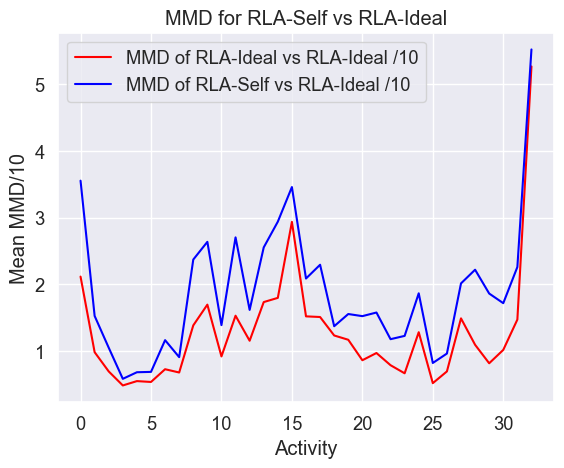

For the activity: 1
mmd_1_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  3.892424     2.381086
33    2         1  5.493603     1.407215
66    3         1  5.754891     1.758275
99    4         1  5.616320     1.460942
132   5         1  3.506416     2.485705
164   7         1  3.560422     2.689779
197   8         1  3.359694     2.323884
230   9         1  6.242684     0.851760
263  10         1  3.522836     2.782010
296  11         1  3.708205     2.059966
327  12         1  4.069855     2.388725
357  13         1  7.399182     0.548718
387  14         1  6.135923     0.813351
417  15         1  3.416835     2.554996
447  16         1  3.176935     2.395122
mmd_2_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  2.549017     1.432009
33    2         

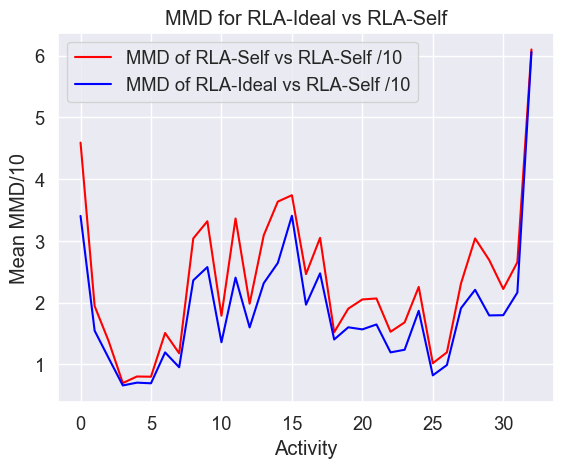

For the activity: 1
mmd_1_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  1.417425     1.122848
33    2         1  1.127047     0.943543
66    3         1  1.331423     1.085923
98    4         1  1.063445     0.873034
127   5         1  1.064830     0.977314
163   8         1  1.247653     0.816967
196   9         1  1.411737     1.139430
229  10         1  1.049420     0.994358
262  11         1  1.572272     1.071991
295  12         1  2.464045     1.380356
327  13         1  1.812342     1.056078
360  14         1  0.947832     0.920748
393  15         1  1.092581     1.013352
423  16         1  2.101839     1.124186
456  17         1  1.776313     1.182963
mmd_2_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  2.801111     2.305898
33    2         

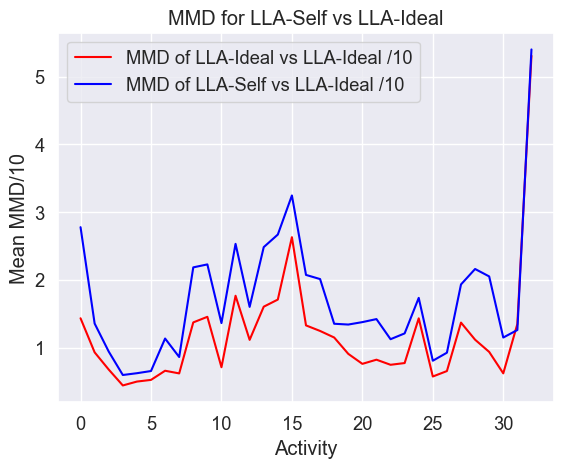

For the activity: 1
mmd_1_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  2.700990     2.479659
33    2         1  3.012766     2.456518
66    3         1  3.752587     2.615113
99    4         1  5.964629     1.273729
132   5         1  5.372528     0.821852
164   7         1  2.985746     2.306068
197   8         1  2.761445     2.047107
230   9         1  3.327111     2.435266
263  10         1  2.700467     2.451343
296  11         1  2.889214     1.982688
327  12         1  5.693182     1.195586
357  13         1  7.189017     0.534917
387  14         1  2.374058     2.254950
417  15         1  2.810290     2.191379
447  16         1  3.434455     1.813401
mmd_2_1_activity has count: CV             15
activity       15
mmd            15
std_div_mmd    15
dtype: int64
     CV  activity       mmd  std_div_mmd
0     1         1  1.169309     0.981366
33    2         

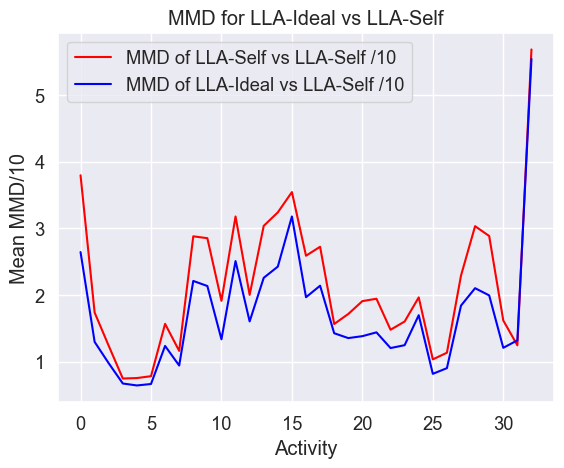

In [32]:
corr_data = {}
df = pd.DataFrame()
for pair in sensor_list_realdisp:
    sensor_test = pair[0]
    sensor_train = pair[1]
    var_type = check_var(sensor_test, sensor_train)
    result_list = []

    for i in range(num_participants_realdisp):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break

            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test, 'model_type': model,
                            'var_type': var_type, 'has_var': False}
            result_list.append(dict_results)
            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_train + ' vs ' + sensor_test, 'model_type': model,
                            'var_type': var_type, 'has_var': True}
            result_list.append(dict_results)

    df = pd.concat([df, pd.DataFrame(result_list)], ignore_index=True)

    file_activity = 'using_3d_per_activity/old'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    activity_mmd_1_1 = pd.DataFrame()
    activity_mmd_2_1 = pd.DataFrame()
    for activity in mmd_1_1['activity'].unique():
        mmd_1_1_activity = mmd_1_1[(mmd_1_1['activity'] == activity)]
        mmd_2_1_activity = mmd_2_1[mmd_2_1['activity'] == activity]

        print("For the activity: " + str(activity))
        print("mmd_1_1_activity has count: " + str(mmd_1_1_activity.count()))
        print(mmd_1_1_activity)
        print("mmd_2_1_activity has count: " + str(mmd_2_1_activity.count()))
        print(mmd_2_1_activity)
        '''' Get the mean for all activities for each cv '''
        mmd_1_1_activity = mmd_1_1_activity.mean()['mmd']
        mmd_2_1_activity = mmd_2_1_activity.mean()['mmd']

        activity_mmd_1_1 = pd.concat([activity_mmd_1_1, pd.DataFrame({'activity': activity, 'mmd': mmd_1_1_activity},
                                                                     index=[0])], ignore_index=True)
        activity_mmd_2_1 = pd.concat([activity_mmd_2_1, pd.DataFrame({'activity': activity, 'mmd': mmd_2_1_activity},
                                                                     index=[0])], ignore_index=True)

    # plot line graph for each activity with 1_1 being red and 2_1 being blue
    sns.lineplot(data=activity_mmd_1_1['mmd'], color='red',
                 label='MMD of ' + sensor_abbrev[sensor_test] + ' vs ' + sensor_abbrev[sensor_test] + ' /10')
    sns.lineplot(data=activity_mmd_2_1['mmd'], color='blue',
                 label='MMD of ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test] + ' /10')
    plt.title('MMD for ' + sensor_abbrev[sensor_train] + ' vs ' + sensor_abbrev[sensor_test])
    plt.xlabel('Activity')
    plt.ylabel('Mean MMD/10')
    plt.show()





# # reset the index
# mmd_1_1 = mmd_1_1.reset_index(drop=True)
# mmd_2_1 = mmd_2_1.reset_index(drop=True)
#
# # set the CV values to be 1 to len
# len_df = len(mmd_1_1)
# mmd_1_1['CV'] = range(1, len_df + 1)
# mmd_2_1['CV'] = range(1, len_df + 1)

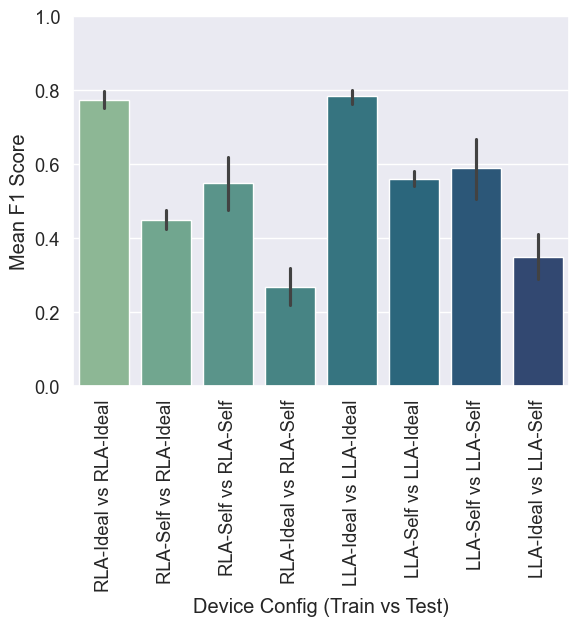

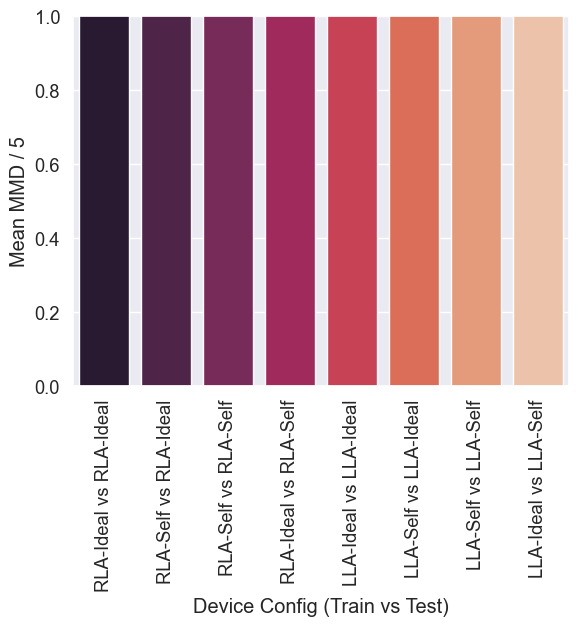

In [33]:
ax = sns.barplot(x='device_config', y='f1', data=combined_mean_data, palette='crest')
# set the ylim to 1
plt.ylim(0, 1)
# rename the x ticks to be Train and Test
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(rotation=90)
for i in range(len(labels)):
    label = labels[i]
    label = label.replace('Train(', '')
    label = label.replace(')', '')
    label = label.replace('Test(', '')
    labels[i] = label

ax.set_xticklabels(labels)
# set X axis label to be Device Config
plt.xlabel('Device Config (Train vs Test)')
# set Y axis label to be F1 Score
plt.ylabel('Mean F1 Score')
plt.show()

# plot the mean mmd values
ax = sns.barplot(x='device_config', y='mmd', data=combined_mean_mmd, palette='rocket')
# set the ylim to 1
plt.ylim(0, 1)
# rename the x ticks to be Train and Test
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(rotation=90)
for i in range(len(labels)):
    label = labels[i]
    label = label.replace('Train(', '')
    label = label.replace(')', '')
    label = label.replace('Test(', '')
    label = label.replace('F1 of ', '')
    labels[i] = label
ax.set_xticklabels(labels)
# set X axis label to be Device Config
plt.xlabel('Device Config (Train vs Test)')
# set Y axis label to be Mean MMD
plt.ylabel('Mean MMD / 5')
plt.show()


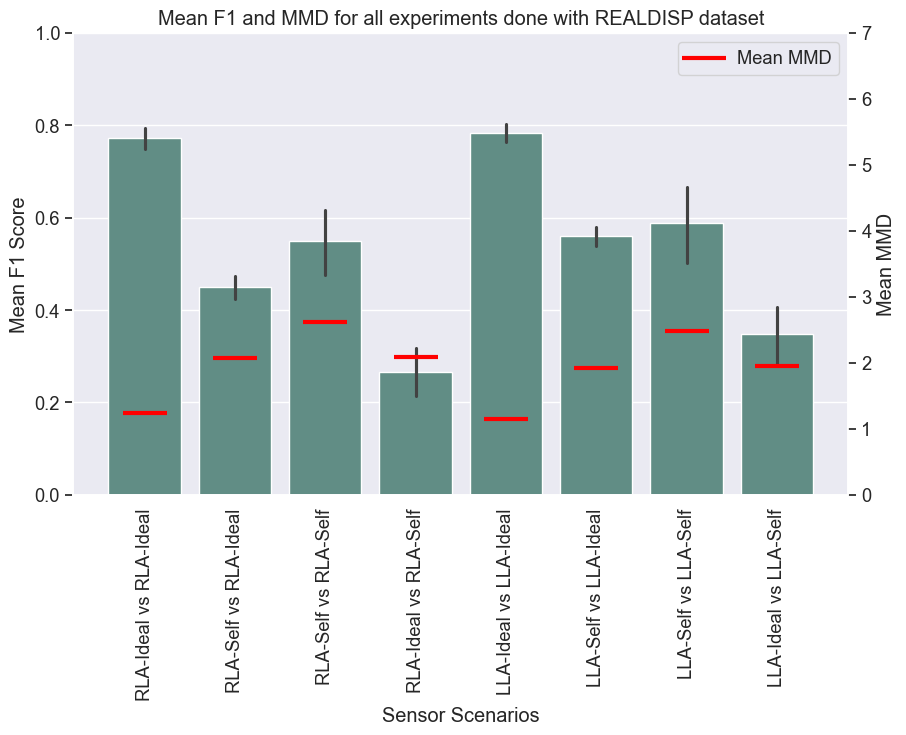

In [34]:
# remove filler text in combined_mean_data
for i in range(len(combined_mean_data)):
    combined_mean_data['device_config'][i] = combined_mean_data['device_config'][i].replace('F1 of ', '')
    combined_mean_data['device_config'][i] = combined_mean_data['device_config'][i].replace('Train(', '')
    combined_mean_data['device_config'][i] = combined_mean_data['device_config'][i].replace(')', '')
    combined_mean_data['device_config'][i] = combined_mean_data['device_config'][i].replace('Test(', '')
# replace filler text in combined_mean_mmd
for i in range(len(combined_mean_mmd)):
    combined_mean_mmd['device_config'][i] = combined_mean_mmd['device_config'][i].replace('F1 of ', '')
    combined_mean_mmd['device_config'][i] = combined_mean_mmd['device_config'][i].replace('Train(', '')
    combined_mean_mmd['device_config'][i] = combined_mean_mmd['device_config'][i].replace(')', '')
    combined_mean_mmd['device_config'][i] = combined_mean_mmd['device_config'][i].replace('Test(', '')

# # create a vertical subplot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
# # plot the mean f1 score for each device config
# sns.barplot(x='device_config', y='f1', data=combined_mean_data, palette='crest', ax=ax1)
# # set the ylim to 1
# ax1.set_ylim(0, 1)
# # dont print any x ticks or x label
# ax1.set_xticks([])
# ax1.set_xlabel('')
# ax1.set_ylabel('Mean F1 Score')
# ax1.set_title('Mean F1 Score and MMD for each Device Config')
# # plot the mean mmd values for each device config
# sns.barplot(x='device_config', y='mmd', data=combined_mean_mmd, palette='rocket', ax=ax2)
# # set the ylim to 1
# ax2.set_ylim(0, 1)
# # set x ticks at 90 degrees
# plt.xticks(rotation=90)
# # set X axis label to be Device Config
# ax2.set_xlabel('Device Config (Train vs Test)')
# # set Y axis label to be Mean MMD
# ax2.set_ylabel('Mean MMD / 5')
# plt.show()


# plot overlapping barplots for combined_mean_data and combined_mean_mmd
fig, ax1 = plt.subplots(figsize=(10, 6))
cus_color = (90 / 255, 148 / 255, 138 / 255, 255 / 255)
ax1 = sns.barplot(x='device_config', y='f1', data=combined_mean_data, color=cus_color, ax=ax1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Sensor Scenarios')
ax1.set_ylabel('Mean F1 Score')
# set x ticks at 90 degrees
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# create a twinplot for ax1
ax2 = ax1.twinx()
# remove gridline for ax2
ax2.grid(False)
# make ax2 ylim 7
ax2.set_ylim(0, 7)
ax2.set_ylabel('Mean MMD')
# add title, Mean F1 and MMD for all experiments done with REALDISP dataset
plt.title('Mean F1 and MMD for all experiments done with REALDISP dataset')

# combine legend for f1 and MMD together on top right


ax2.scatter(combined_mean_mmd['device_config'], combined_mean_mmd['mmd'], color='red', marker='_', linewidths=3, s=1000)
# add a legend for scatter plot
ax2.legend(['Mean MMD'], loc='upper right')

plt.show()


In [35]:
from scipy.stats import f_oneway

# perform an ANOVA test for all the device configs in combined_mean_data
# get the unique device configs
device_configs = combined_mean_data['device_config'].unique()
# get the f1 scores for each device config
f1_scores = [combined_mean_data[combined_mean_data['device_config'] == device_config]['f1'] for device_config in
             device_configs]
# perform the ANOVA test
anova = f_oneway(*f1_scores)
print(anova)

F_onewayResult(statistic=50.064725200515596, pvalue=4.138960890341793e-50)
